TODO: 
- parallax?? check out the `plx` branch but optimization wasn't working
- Gaia selection function
- Iterate: Use this to improve the distance trend and CMD selection

In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci
import blackjax

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

from gd1_helpers.membership import Model, BackgroundModel, StreamModel, JointModel, SpurModel
from gd1_helpers.membership.plot import plot_data_projections, plot_model_projections

model has 322 parameters


In [2]:
data_path = pathlib.Path('../data').resolve().absolute()
cache_path = pathlib.Path('../cache').resolve().absolute()

# Base model class and helper functions

See: `3-Initial-stream-track.ipynb`

In [3]:
g = GaiaData(data_path / 'gd1-GaiaDR3-PS1DR2-joined.fits')

phi2_mask = (g.gd1_phi2 > Model.phi2_cut[0]) & (g.gd1_phi2 < Model.phi2_cut[1])
g = g[phi2_mask]

len(g)

6520791

In [4]:
masks = at.Table.read(cache_path / 'init-masks.fits')[phi2_mask]
masks['G19.5'] = g.phot_g_mean_mag < 19.5*u.mag

In [5]:
with open(data_path / 'galcen_frame.pkl', 'rb') as f:
    galcen_frame = pickle.load(f)

In [6]:
c = g.get_skycoord(
    distance=coord.Distance(distmod=g.rough_distmod),
    radial_velocity=0*u.km/u.s
)
gd1_frame = gc.GD1Koposov10()
c_gd1 = c.transform_to(gd1_frame)
c_gd1_refl = gc.reflex_correct(c_gd1, galcen_frame)

Note: We use a past distance trend (de Boer paper) to compute initial solar reflex-corrected proper motions, but do a conservative cut using these.

In [7]:
pm_cov = g.get_cov()[:, 3:5, 3:5]
pm_cov_gd1 = gc.transform_pm_cov(c, pm_cov, gd1_frame)

pm1 = c_gd1_refl.pm_phi1_cosphi2.value
pm2 = c_gd1_refl.pm_phi2.value
pm1_err = np.sqrt(pm_cov_gd1[:, 0, 0])
pm2_err = np.sqrt(pm_cov_gd1[:, 1, 1])

masks['pm1_cut'] = (pm1 < Model.pm1_cut[1]) & (pm1 > Model.pm1_cut[0])

In [8]:
all_data = {
    'phi1': c_gd1.phi1.degree,
    'phi2': c_gd1.phi2.degree,
    'pm1': pm1,
    'pm1_error': pm1_err,
    'pm2': pm2,
    'pm2_error': pm2_err,
}

for k, v in all_data.items():
    all_data[k] = np.array(v, copy=True, dtype=np.float64)
    assert np.all(np.isfinite(all_data[k]))

# Stream and background trends

For membership modeling, we are going to do initial cuts on:
- apparent G magnitude, $G < 19.5$
- in CMD mask using distance trend from de Boer
- proper motion filter to remove bulk of disk/halo

In [9]:
def get_pcls(x, y, phi1_bins, qs=None):
    if qs is None:
        qs = [5, 16, 50, 84, 95]
    
    pcls = {}
    for q in [5, 16, 50, 84, 95]:
        stat = scs.binned_statistic(
            x, 
            y, 
            bins=phi1_bins,
            statistic=lambda x: np.percentile(x, q)
        )
        pcls[q] = stat.statistic
    return pcls

Text(0, 0.5, '$\\mu_{\\phi_2}$')

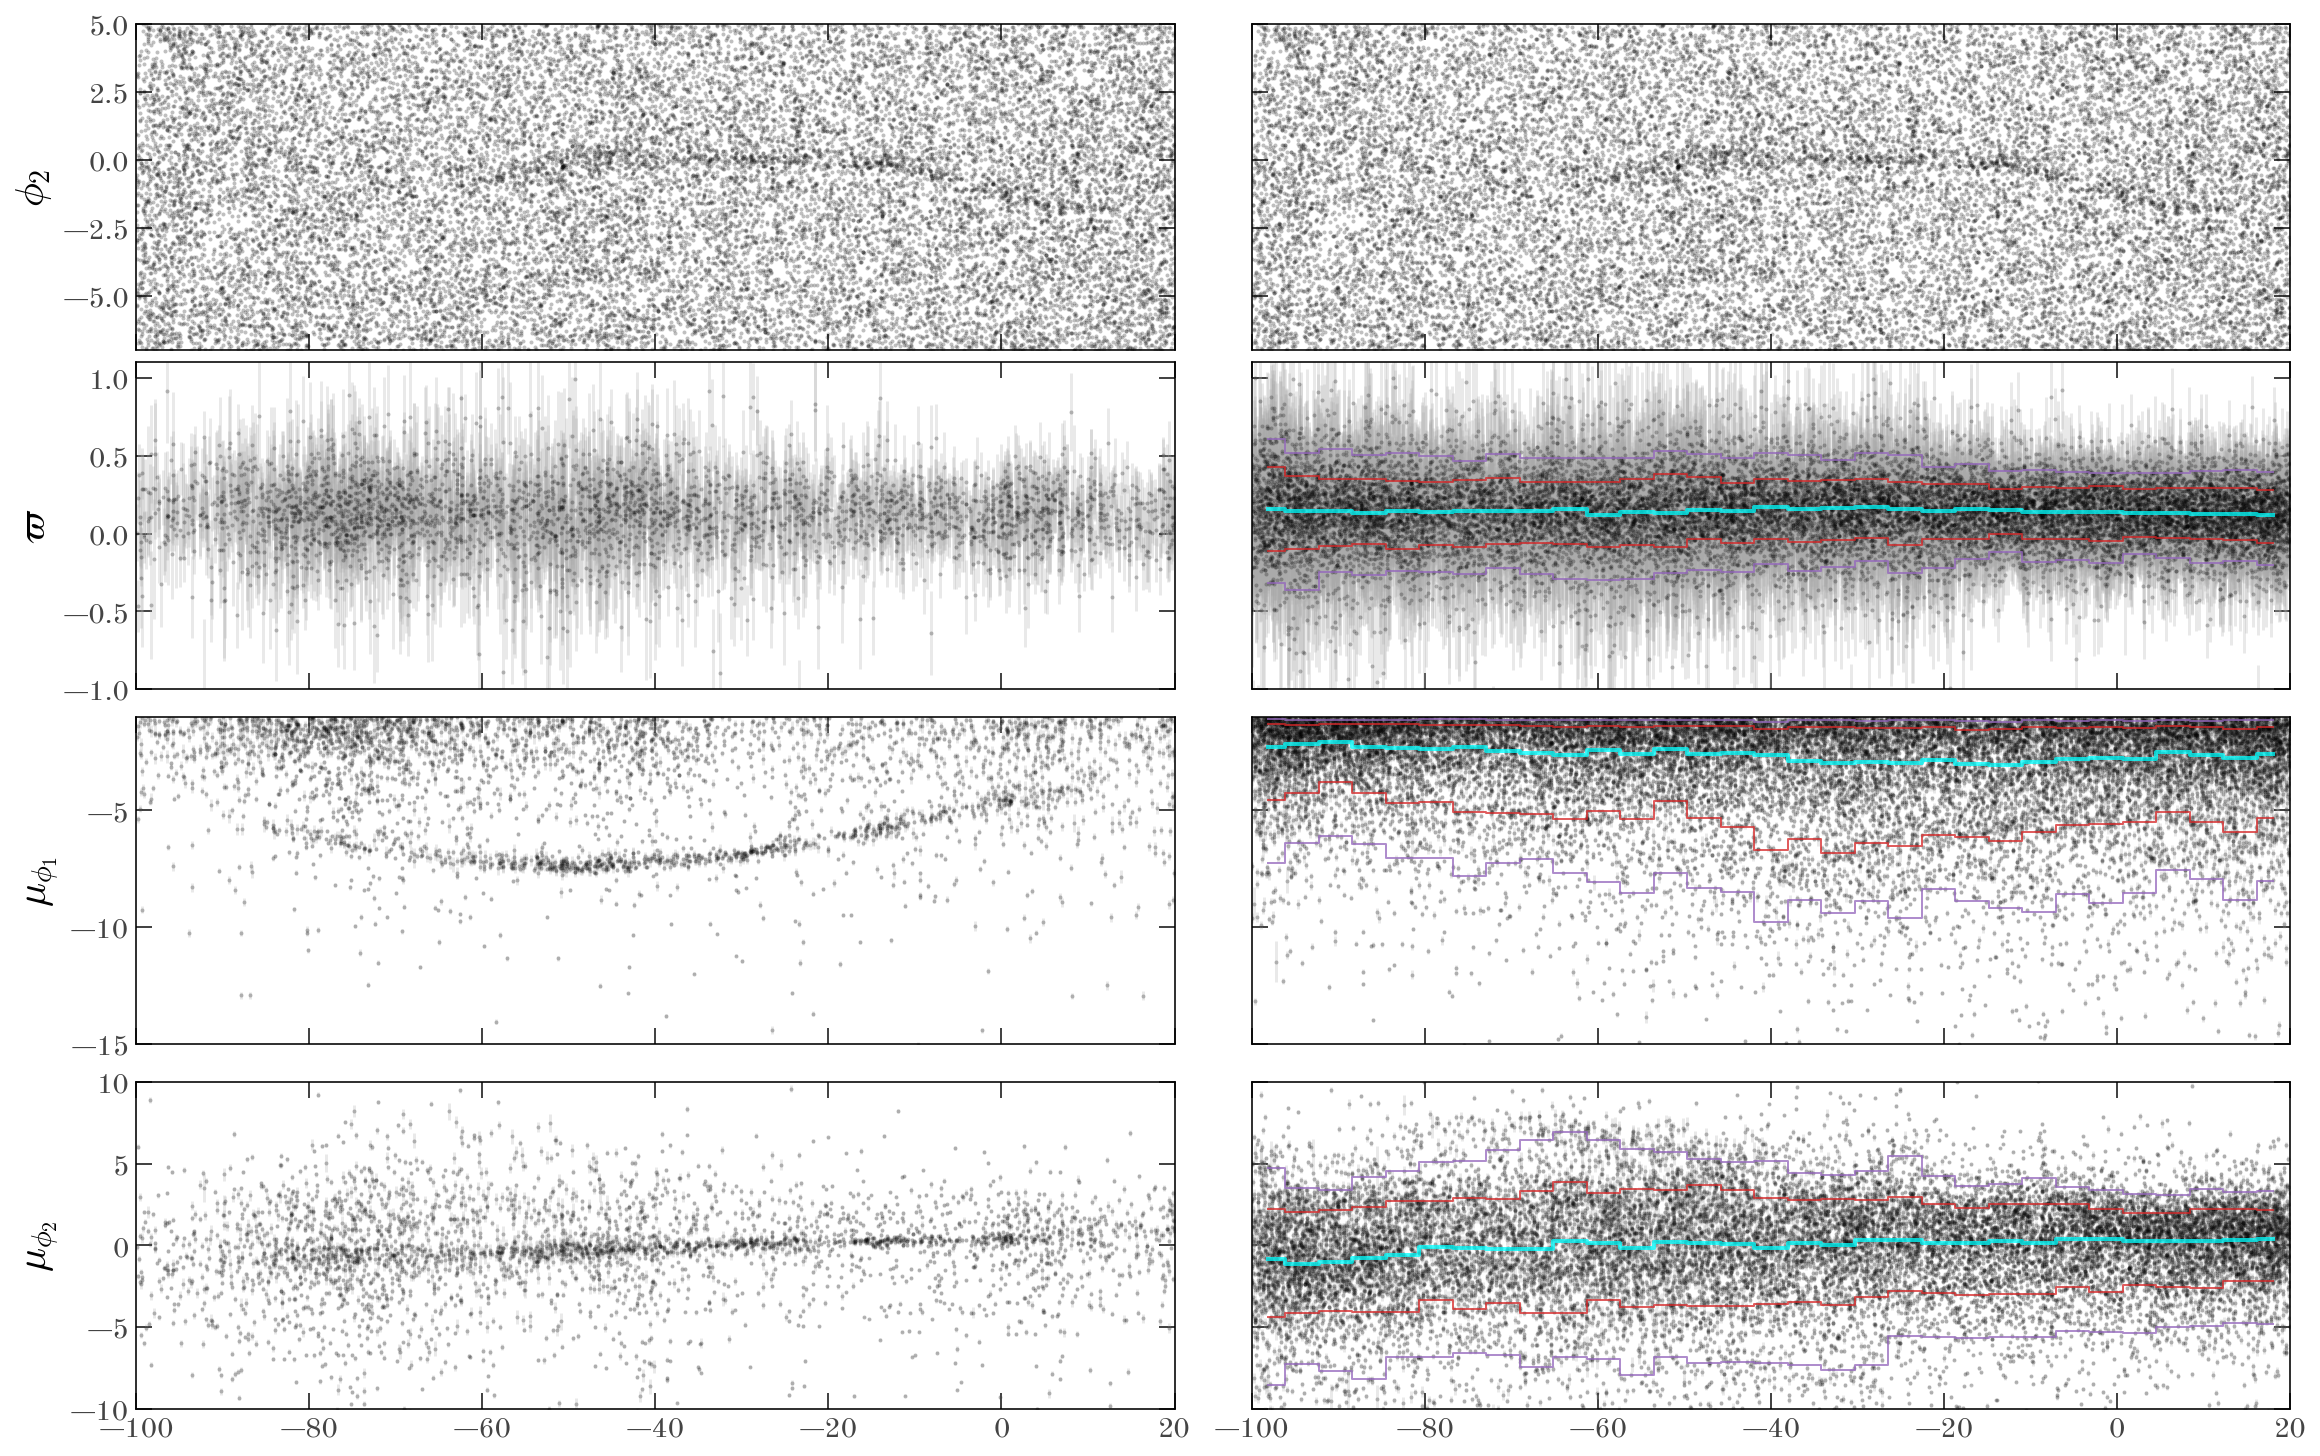

In [10]:
_base_mask = masks['cmd_ms'] & masks['G19.5'] & masks['pm1_cut']
phi1_bins = np.linspace(-100, 20, 32)
phi1_binc = 0.5 * (phi1_bins[:-1] + phi1_bins[1:])
style = dict(
    ls='none',
    marker='o',
    mew=0, 
    ms=2.,
    ecolor='#aaaaaa',
    alpha=0.25
)

fig, axes = plt.subplots(4, 2, figsize=(16, 10), 
                         sharex=True, sharey='row', constrained_layout=True)


mask1 = _base_mask
mask2 = _base_mask
axes[0, 0].errorbar(g.gd1_phi1[mask1], g.gd1_phi2[mask1], **style)
axes[0, 1].errorbar(g.gd1_phi1[mask2], g.gd1_phi2[mask2], **style)
axes[0, 0].set_ylim(-7, 5.)

mask1 = _base_mask & masks['sky_track']
mask2 = _base_mask & ~masks['sky_track']

ys = [g.parallax.value, c_gd1_refl.pm_phi1_cosphi2.value, c_gd1_refl.pm_phi2.value]
yerrs = [g.parallax_error.value, np.sqrt(pm_cov_gd1[:, 0, 0]), np.sqrt(pm_cov_gd1[:, 1, 1])]
for i, y, yerr in zip(range(1, 3+1), ys, yerrs):
    for ax, mask in zip(axes[i], [mask1, mask2]):
        ax.errorbar(g.gd1_phi1[mask], y[mask], yerr[mask], **style)
        
    # only do for background plots:
    pcls = get_pcls(g.gd1_phi1[mask], y[mask], phi1_bins)
    ax.plot(phi1_binc, pcls[50], marker='', drawstyle='steps-mid', 
            color='cyan', lw=2, alpha=0.75, zorder=100)
    
    for j in [16, 84]:
        ax.plot(phi1_binc, pcls[j], marker='', drawstyle='steps-mid', 
                color='tab:red', lw=1, alpha=0.75, zorder=100)
    
    for j in [5, 95]:
        ax.plot(phi1_binc, pcls[j], marker='', drawstyle='steps-mid', 
                color='tab:purple', lw=1, alpha=0.75, zorder=100)
                  
axes[1, 0].set_ylim(-1, 1.1)
axes[2, 0].set_ylim(-15, Model.pm1_cut[1])
axes[3, 0].set_ylim(-10, 10)

axes[0, 0].set_xlim(-100, 20)
axes[0, 0].set_ylabel(r'$\phi_2$')
axes[1, 0].set_ylabel(r'$\varpi$')
axes[2, 0].set_ylabel(r'$\mu_{\phi_1}$')
axes[3, 0].set_ylabel(r'$\mu_{\phi_2}$')

# Background model


## Initialization

As an example and for initialization, we determine initial parameters from the area outside the sky track:

In [11]:
bkg_init_p = {}

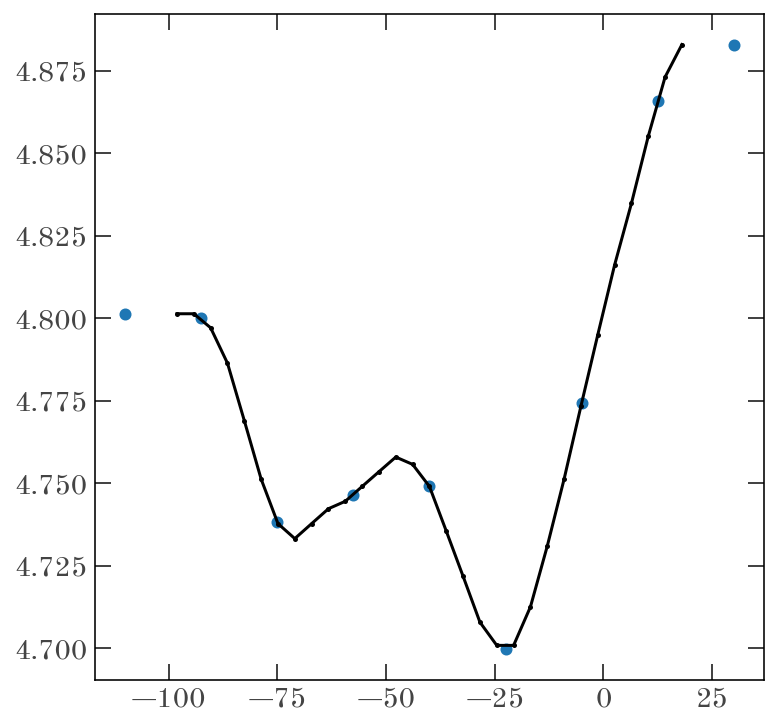

In [12]:
mask = _base_mask

tmp_lim = (-3, 1)
H, _ = np.histogram(
    g.gd1_phi1[mask & ((g.gd1_phi2 < tmp_lim[0]) | (g.gd1_phi2 > tmp_lim[1]))], 
    bins=phi1_bins
)

dx = phi1_bins[1] - phi1_bins[0]
H = np.log(scn.gaussian_filter(H, 2.) / dx)
plt.errorbar(phi1_binc, H)

tmp = sci.InterpolatedUnivariateSpline(phi1_binc, H, ext=3)
bkg_init_p['ln_n0'] = tmp(BackgroundModel.ln_n0_knots)
plt.scatter(
    BackgroundModel.ln_n0_knots, 
    bkg_init_p['ln_n0'], 
    color='tab:blue'
)

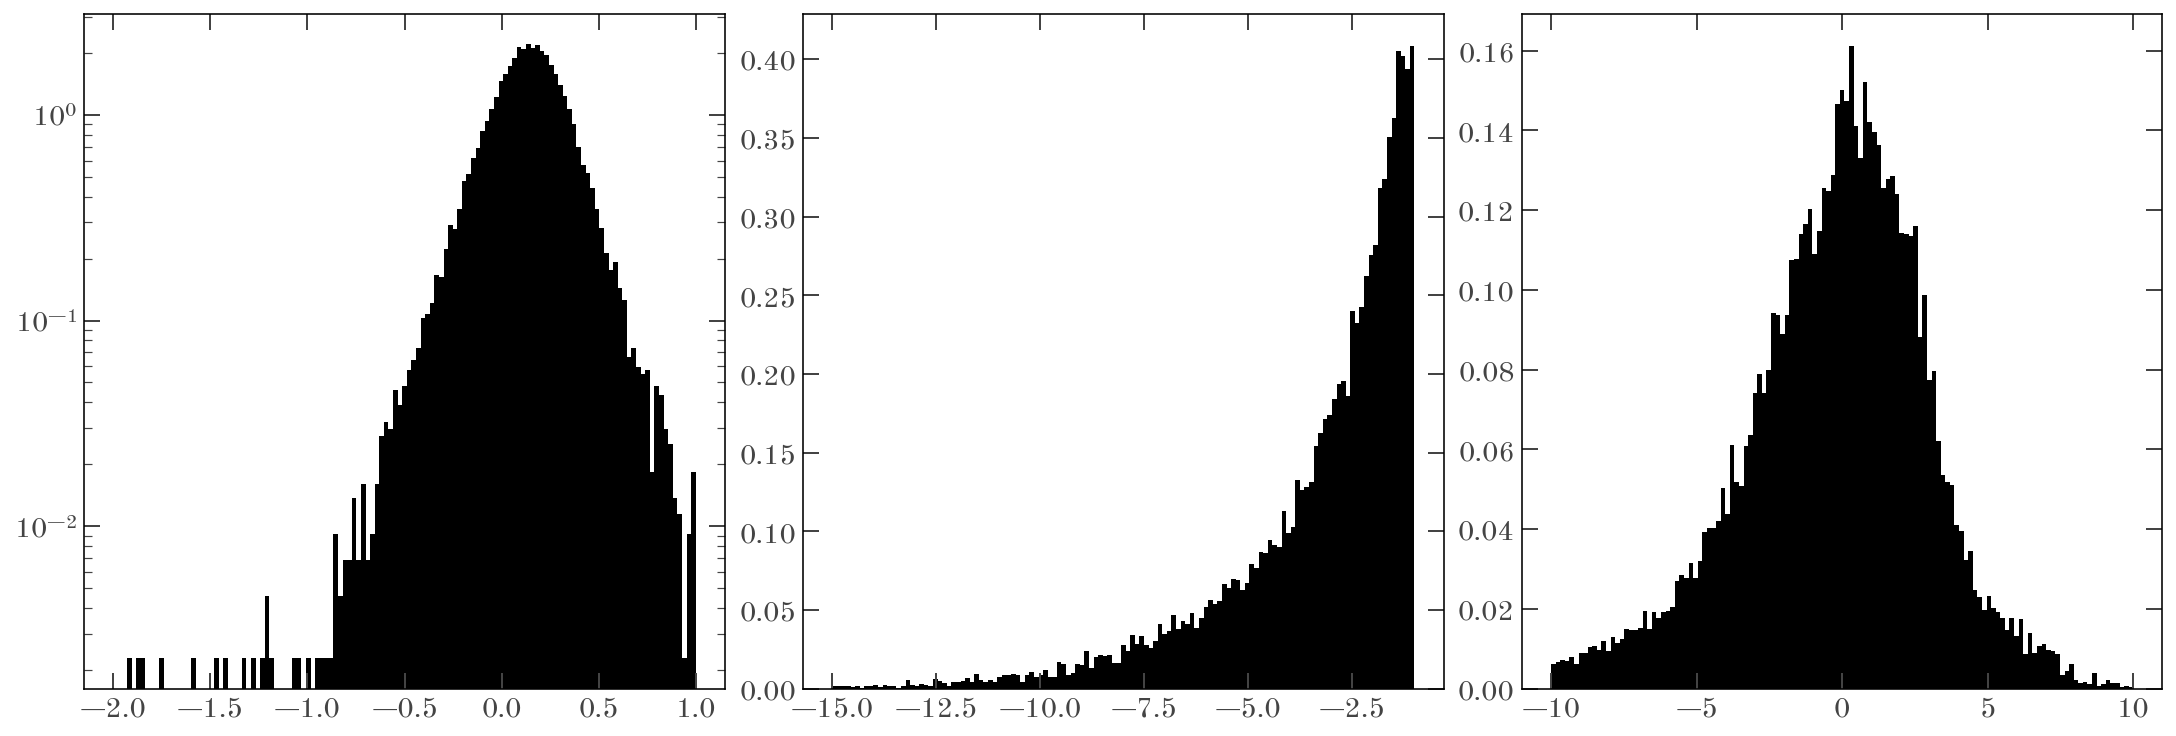

In [13]:
mask = _base_mask & ~masks['sky_track'] #& (g.gd1_phi1 > -20) & (g.gd1_phi1 < 20)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False,
                         constrained_layout=True)

axes[0].hist(g.parallax.value[mask], bins=np.linspace(-2, 1, 128), density=True)
axes[0].set_yscale('log')
axes[1].hist(pm1[mask], bins=np.linspace(-15, Model.pm1_cut[1], 128), density=True)
axes[2].hist(pm2[mask], bins=np.linspace(-10, 10, 128), density=True);

In [14]:
from gd1_helpers.membership.helpers import two_truncnorm_mixture_ln_prob, ln_normal

x0_pm1 = jnp.array([0.65, 0.75, -4, np.log(3), np.log(4)])

@jax.jit
def objective(p, data, data_err):
    ln_prob = two_truncnorm_mixture_ln_prob(p, data, data_err, *Model.pm1_cut)
    ln_prob = ln_prob + ln_normal(p[1], 0, 5) + ln_normal(p[2], 0, 5)
    return - ln_prob.sum() / len(data)

obj_grad = jax.jit(jax.grad(objective))
res_pm1 = sco.minimize(
    objective, 
    x0=x0_pm1,
    jac=lambda x, *args: np.array(obj_grad(x, *args)),
    method='l-bfgs-b',
    bounds=[(0, 1), (-10, 20), (-10, 20), (-5, 5), (-5, 5)],
    args=(pm1[mask], pm1_err[mask] * 0.),
    options=dict(maxls=1000)
)
print(res_pm1)
assert res_pm1.success

      fun: 5.3200899260033685
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.90314160e-06,  2.21718385e-06, -1.46215347e-06, -5.60762745e-06,
       -4.33806490e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([0.54029594, 0.00680771, 0.00313603, 0.67611115, 1.5591491 ])


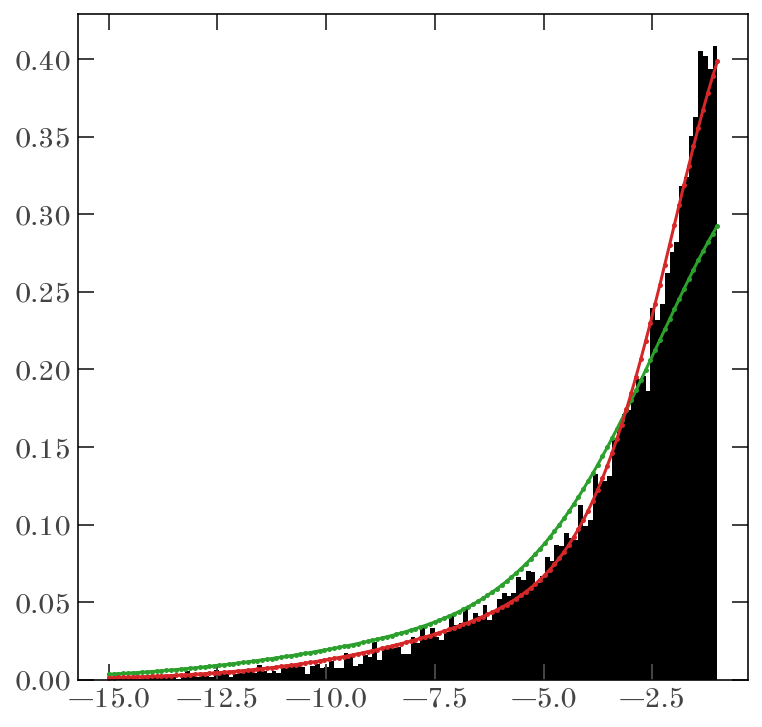

In [15]:
grid = np.linspace(-15, -1, 128)
plt.hist(pm1[mask], bins=np.linspace(-15, -1, 128), density=True)
plt.plot(grid, np.exp(two_truncnorm_mixture_ln_prob(x0_pm1, grid, 0., *Model.pm1_cut)), color='tab:green')
plt.plot(grid, np.exp(two_truncnorm_mixture_ln_prob(res_pm1.x, grid, 0., *Model.pm1_cut)), color='tab:red')

In [16]:
n = 0
for name, size in BackgroundModel.param_names.items():
    if name.endswith('_pm1'):
        bkg_init_p[name] = np.full(size, res_pm1.x[n])
        n += 1 

In [17]:
from gd1_helpers.membership.helpers import two_norm_mixture_ln_prob, ln_normal

x0_pm2 = [0.8, 0.75, -4, np.log(2.5), np.log(4)]

@jax.jit
def objective(p, data, data_err):
    return -two_norm_mixture_ln_prob(p, data, data_err).sum() / len(data)

obj_grad = jax.jit(jax.grad(objective))
res_pm2 = sco.minimize(
    objective, 
    x0=x0_pm2,
    jac=lambda x, *args: np.array(obj_grad(x, *args)),
    method='l-bfgs-b',
    bounds=[(0, 1), (-10, 10), (-10, 10), (-5, 5), (-5, 5)],
    args=(pm2[mask], pm2_err[mask]),
    options=dict(maxls=1000)
)
assert res_pm2.success
res_pm2

      fun: 2.605329745470622
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.76742656e-07,  9.69051156e-09, -9.86831814e-08,  4.02073060e-07,
       -1.34599355e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 28
      nit: 24
     njev: 28
   status: 0
  success: True
        x: array([ 0.71068883,  0.35522364, -2.123647  ,  0.85947703,  1.41360834])

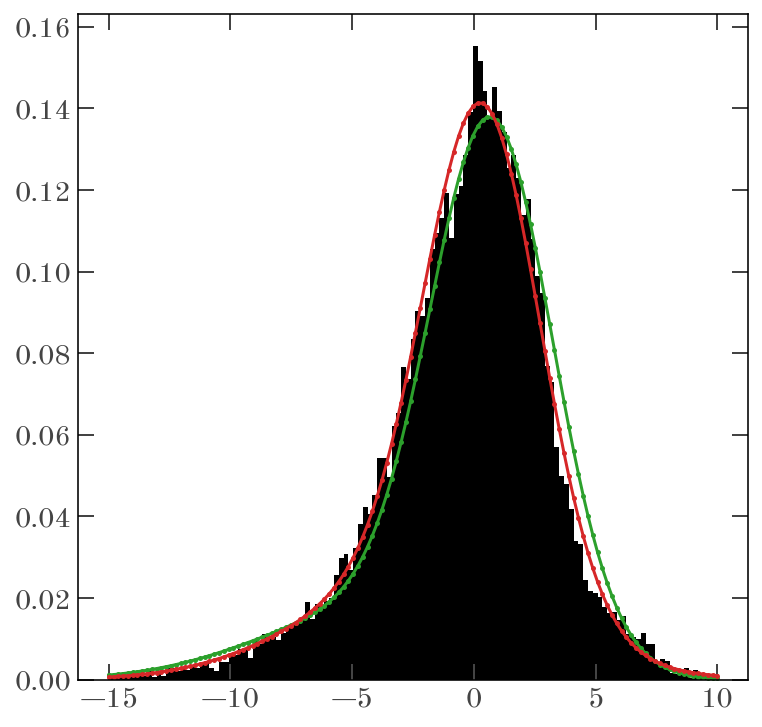

In [18]:
grid = np.linspace(-15, 10, 128)
plt.hist(pm2[mask], bins=np.linspace(-15, 10, 128), density=True)
plt.plot(grid, np.exp(two_norm_mixture_ln_prob(x0_pm2, grid, 0.)), color='tab:green')
plt.plot(grid, np.exp(two_norm_mixture_ln_prob(res_pm2.x, grid, 0.)), color='tab:red')

In [19]:
n = 0
for name, size in BackgroundModel.param_names.items():
    if name.endswith('_pm2'):
        bkg_init_p[name] = np.full(size, res_pm2.x[n])
        n += 1 

In [20]:
bkg_init_p

{'ln_n0': array([4.80135356, 4.80014702, 4.73821655, 4.74653342, 4.74905406,
        4.69973094, 4.77427984, 4.86585683, 4.88286505]),
 'w_pm1': array([0.54029594, 0.54029594, 0.54029594, 0.54029594, 0.54029594,
        0.54029594, 0.54029594]),
 'mean1_pm1': array([0.00680771, 0.00680771, 0.00680771, 0.00680771, 0.00680771,
        0.00680771, 0.00680771]),
 'mean2_pm1': array([0.00313603, 0.00313603, 0.00313603, 0.00313603, 0.00313603,
        0.00313603, 0.00313603]),
 'ln_std1_pm1': array([0.67611115, 0.67611115, 0.67611115, 0.67611115, 0.67611115,
        0.67611115, 0.67611115]),
 'ln_std2_pm1': array([1.5591491, 1.5591491, 1.5591491, 1.5591491, 1.5591491, 1.5591491,
        1.5591491]),
 'w_pm2': array([0.71068883, 0.71068883, 0.71068883, 0.71068883, 0.71068883,
        0.71068883, 0.71068883]),
 'mean1_pm2': array([0.35522364, 0.35522364, 0.35522364, 0.35522364, 0.35522364,
        0.35522364, 0.35522364]),
 'mean2_pm2': array([-2.123647, -2.123647, -2.123647, -2.123647, -2.123

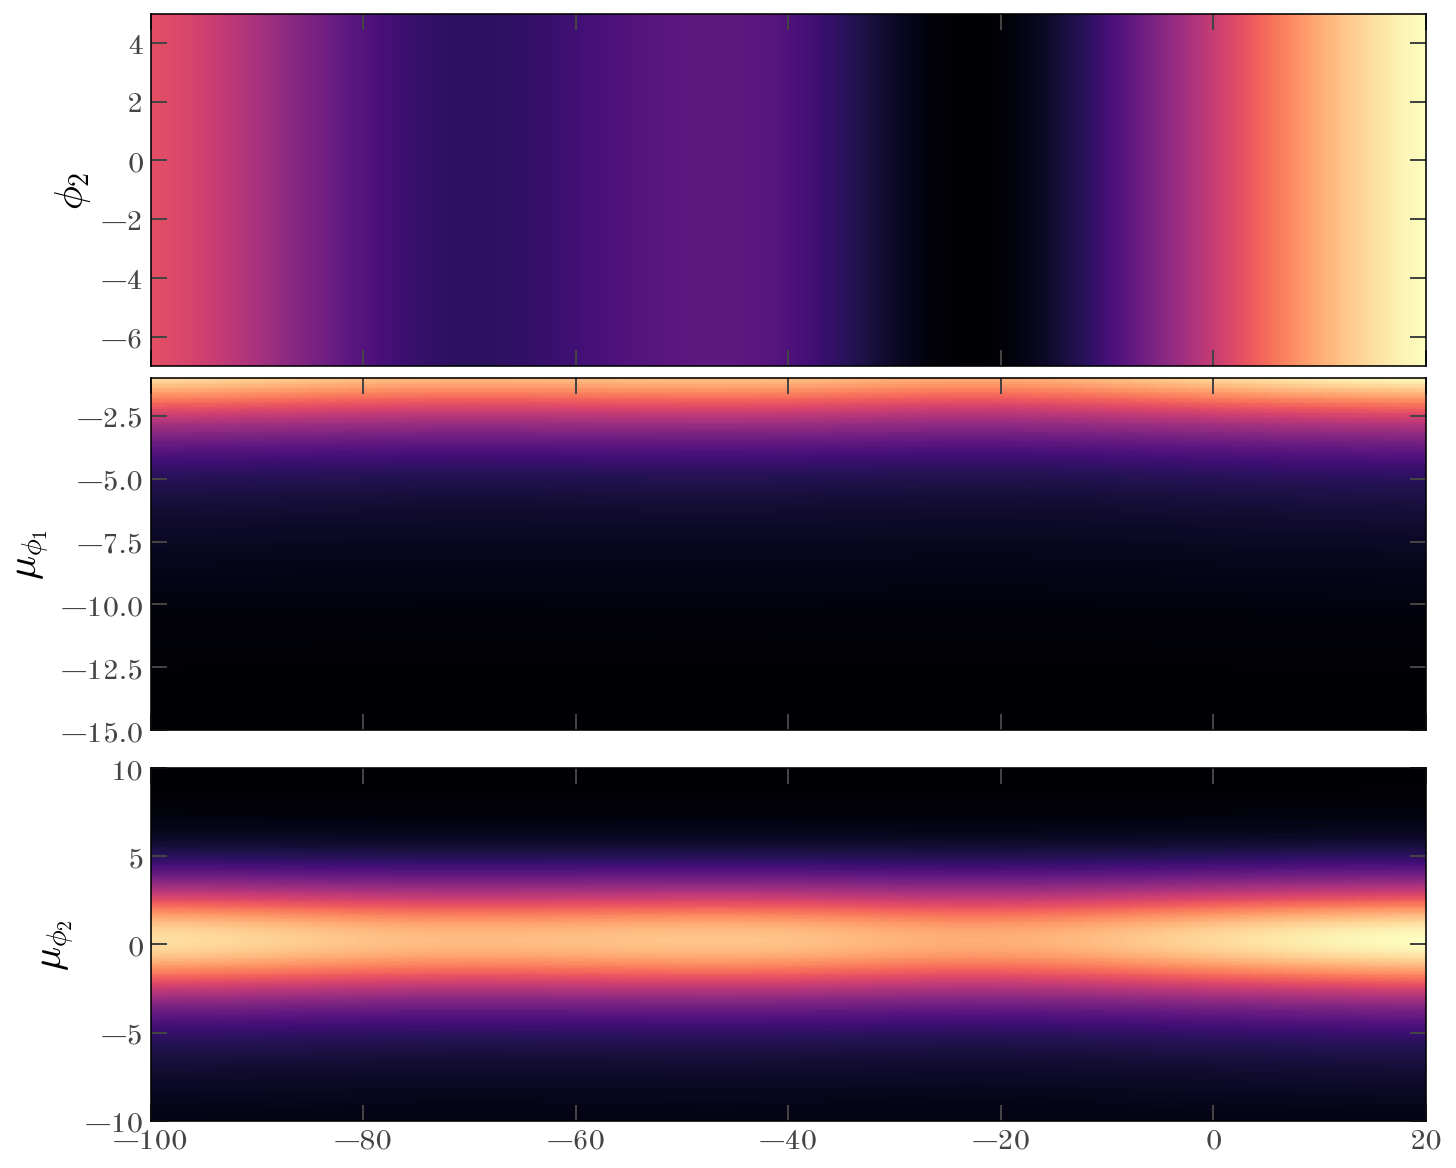

In [21]:
plot_model_projections(
    {'background': bkg_init_p}, 
    components=['background'], 
    plot_stream_knots=False
);

## Test optimization:

In [22]:
bkg_init_pvec = BackgroundModel.pack_pars(bkg_init_p)

In [23]:
test_bkg_mask = masks['cmd_ms'] & masks['G19.5'] & masks['pm1_cut']

data = {
    'phi1': c_gd1.phi1.degree[test_bkg_mask],
    'phi2': c_gd1.phi2.degree[test_bkg_mask],
    'pm1': pm1[test_bkg_mask],
    'pm1_error': pm1_err[test_bkg_mask],
    'pm2': pm2[test_bkg_mask],
    'pm2_error': pm2_err[test_bkg_mask],
}
for k, v in data.items():
    data[k] = np.array(v, copy=True, dtype=np.float64)
    assert np.all(np.isfinite(data[k]))

BackgroundModel.ln_likelihood(bkg_init_p, data)

(DeviceArray(9.55483973, dtype=float64),
 DeviceArray([-1.41964607, -2.15621828, -4.47026591, ..., -0.66241975,
              -1.77040527, -1.47308695], dtype=float64))

In [24]:
BackgroundModel.objective(bkg_init_pvec, len(data['phi1']), data)

DeviceArray(2.86153745, dtype=float64)

In [25]:
func = jax.value_and_grad(BackgroundModel.objective)
func(bkg_init_pvec, test_bkg_mask.sum(), data)

(DeviceArray(2.86153745, dtype=float64),
 DeviceArray([-6.36801387e-04, -4.55711051e-02, -4.80034998e-02,
              -5.15682959e-02, -5.66218819e-02, -4.98329038e-02,
              -5.28246682e-02, -5.25791503e-02, -1.13165131e-03,
              -3.40343848e-03, -4.59451808e-02,  4.05353776e-03,
               3.51383611e-02,  5.05253238e-02,  6.95576514e-03,
              -1.92071381e-04, -2.70825324e-04, -4.09752799e-03,
              -6.17609529e-04, -1.35247330e-06,  2.56302382e-03,
               1.63904264e-03,  4.35501919e-05, -1.55856082e-04,
              -2.36729827e-03, -2.27527270e-04,  1.73152455e-03,
               2.01951428e-03, -1.25206724e-04, -1.78967061e-05,
               1.65569611e-03,  2.42363876e-02,  1.90746350e-03,
              -4.52141062e-03, -2.16230720e-02, -1.00075179e-02,
              -1.12087586e-04,  1.36392853e-03,  2.22097580e-02,
               4.32786489e-03, -1.57304811e-02, -2.01305180e-02,
               7.76085597e-04,  1.60479193e-04,  

In [26]:
_tmp_l = BackgroundModel.pack_pars(
    {k: np.full(BackgroundModel.param_names[k], v[0], dtype='f8') 
    for k, v in BackgroundModel.param_bounds.items()}
)
_tmp_r = BackgroundModel.pack_pars(
    {k: np.full(BackgroundModel.param_names[k], v[1], dtype='f8')
    for k, v in BackgroundModel.param_bounds.items()}
)
bkg_bounds = np.stack((_tmp_l, _tmp_r)).T
assert bkg_bounds.shape[0] == bkg_init_pvec.shape[0]

for i in range(bkg_init_pvec.shape[0]):
    assert bkg_bounds[i, 0] < bkg_init_pvec[i] < bkg_bounds[i, 1]

In [27]:
bkg_grad = jax.jit(jax.grad(BackgroundModel.objective))
bkg_res = sco.minimize(
    BackgroundModel.objective, 
    x0=bkg_init_pvec,
    jac=lambda x, *args: np.array(bkg_grad(x, *args)),
    args=(test_bkg_mask.sum(), data),
    bounds=bkg_bounds,
    method="l-bfgs-b",
    options=dict(maxiter=100_000, maxls=1000),
)
print(bkg_res)
assert bkg_res.success

bkg_res_p =  BackgroundModel.unpack_pars(bkg_res.x)
bkg_res_p

      fun: 2.7323889459394564
 hess_inv: <79x79 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.38932686e-07,  3.99491917e-08, -6.68702678e-08,  1.21252896e-07,
       -1.32026336e-07,  1.24047610e-07, -4.86385532e-08,  2.10086166e-08,
        4.13087237e-07, -1.37013164e-07,  9.29929912e-06, -6.81010705e-07,
        5.48324797e-06, -7.70723152e-06,  9.82211151e-07,  4.53185615e-05,
        5.56622060e-07,  2.87362354e-06,  4.08046747e-07, -1.54858304e-06,
        7.04207280e-07,  2.14735984e-06,  8.10496481e-07, -1.88985012e-06,
       -5.45606037e-07, -1.18067513e-06, -2.19012373e-06, -1.68474993e-08,
       -9.41633583e-07, -2.71550784e-06,  1.56645625e-06, -1.18739779e-06,
       -8.55148414e-06,  1.14747693e-06, -4.99693002e-06, -5.83921053e-07,
        6.51425580e-06,  1.38249845e-06, -7.51269306e-06,  2.03670834e-06,
       -2.81976115e-06, -1.16753395e-06,  6.31864775e-06,  4.86902477e-06,
        5.27516340e-06, -9.80478502e-06, -6.44676478e-06, -2.30177783e-06,
 

{'ln_n0': DeviceArray([4.83522793, 5.23479231, 5.14795448, 5.19595485, 5.23254043,
              5.14582525, 5.22064881, 5.31074918, 5.41024182],            dtype=float64),
 'ln_std1_pm1': DeviceArray([1.74190776, 1.4752882 , 1.02486161, 0.18257138, 0.96578511,
              1.46222313, 1.33102641], dtype=float64),
 'ln_std1_pm2': DeviceArray([1.42795251, 0.91584072, 1.18104353, 0.86371325, 0.61812075,
              0.49687688, 0.7000942 ], dtype=float64),
 'ln_std2_pm1': DeviceArray([1.91027888, 1.72474432, 1.68494653, 1.77076428, 1.85599863,
              1.90910559, 2.03251928], dtype=float64),
 'ln_std2_pm2': DeviceArray([1.75820386, 1.34061192, 1.50886258, 1.43917115, 1.35006804,
              1.18538313, 1.29989344], dtype=float64),
 'mean1_pm1': DeviceArray([ 9.85054662,  9.83055738,  4.16704077, -0.82952135,
               3.7359795 ,  5.82875315,  6.81295273], dtype=float64),
 'mean1_pm2': DeviceArray([-0.25037844, -0.28166384,  0.40864038,  0.53325781,
               0.668019

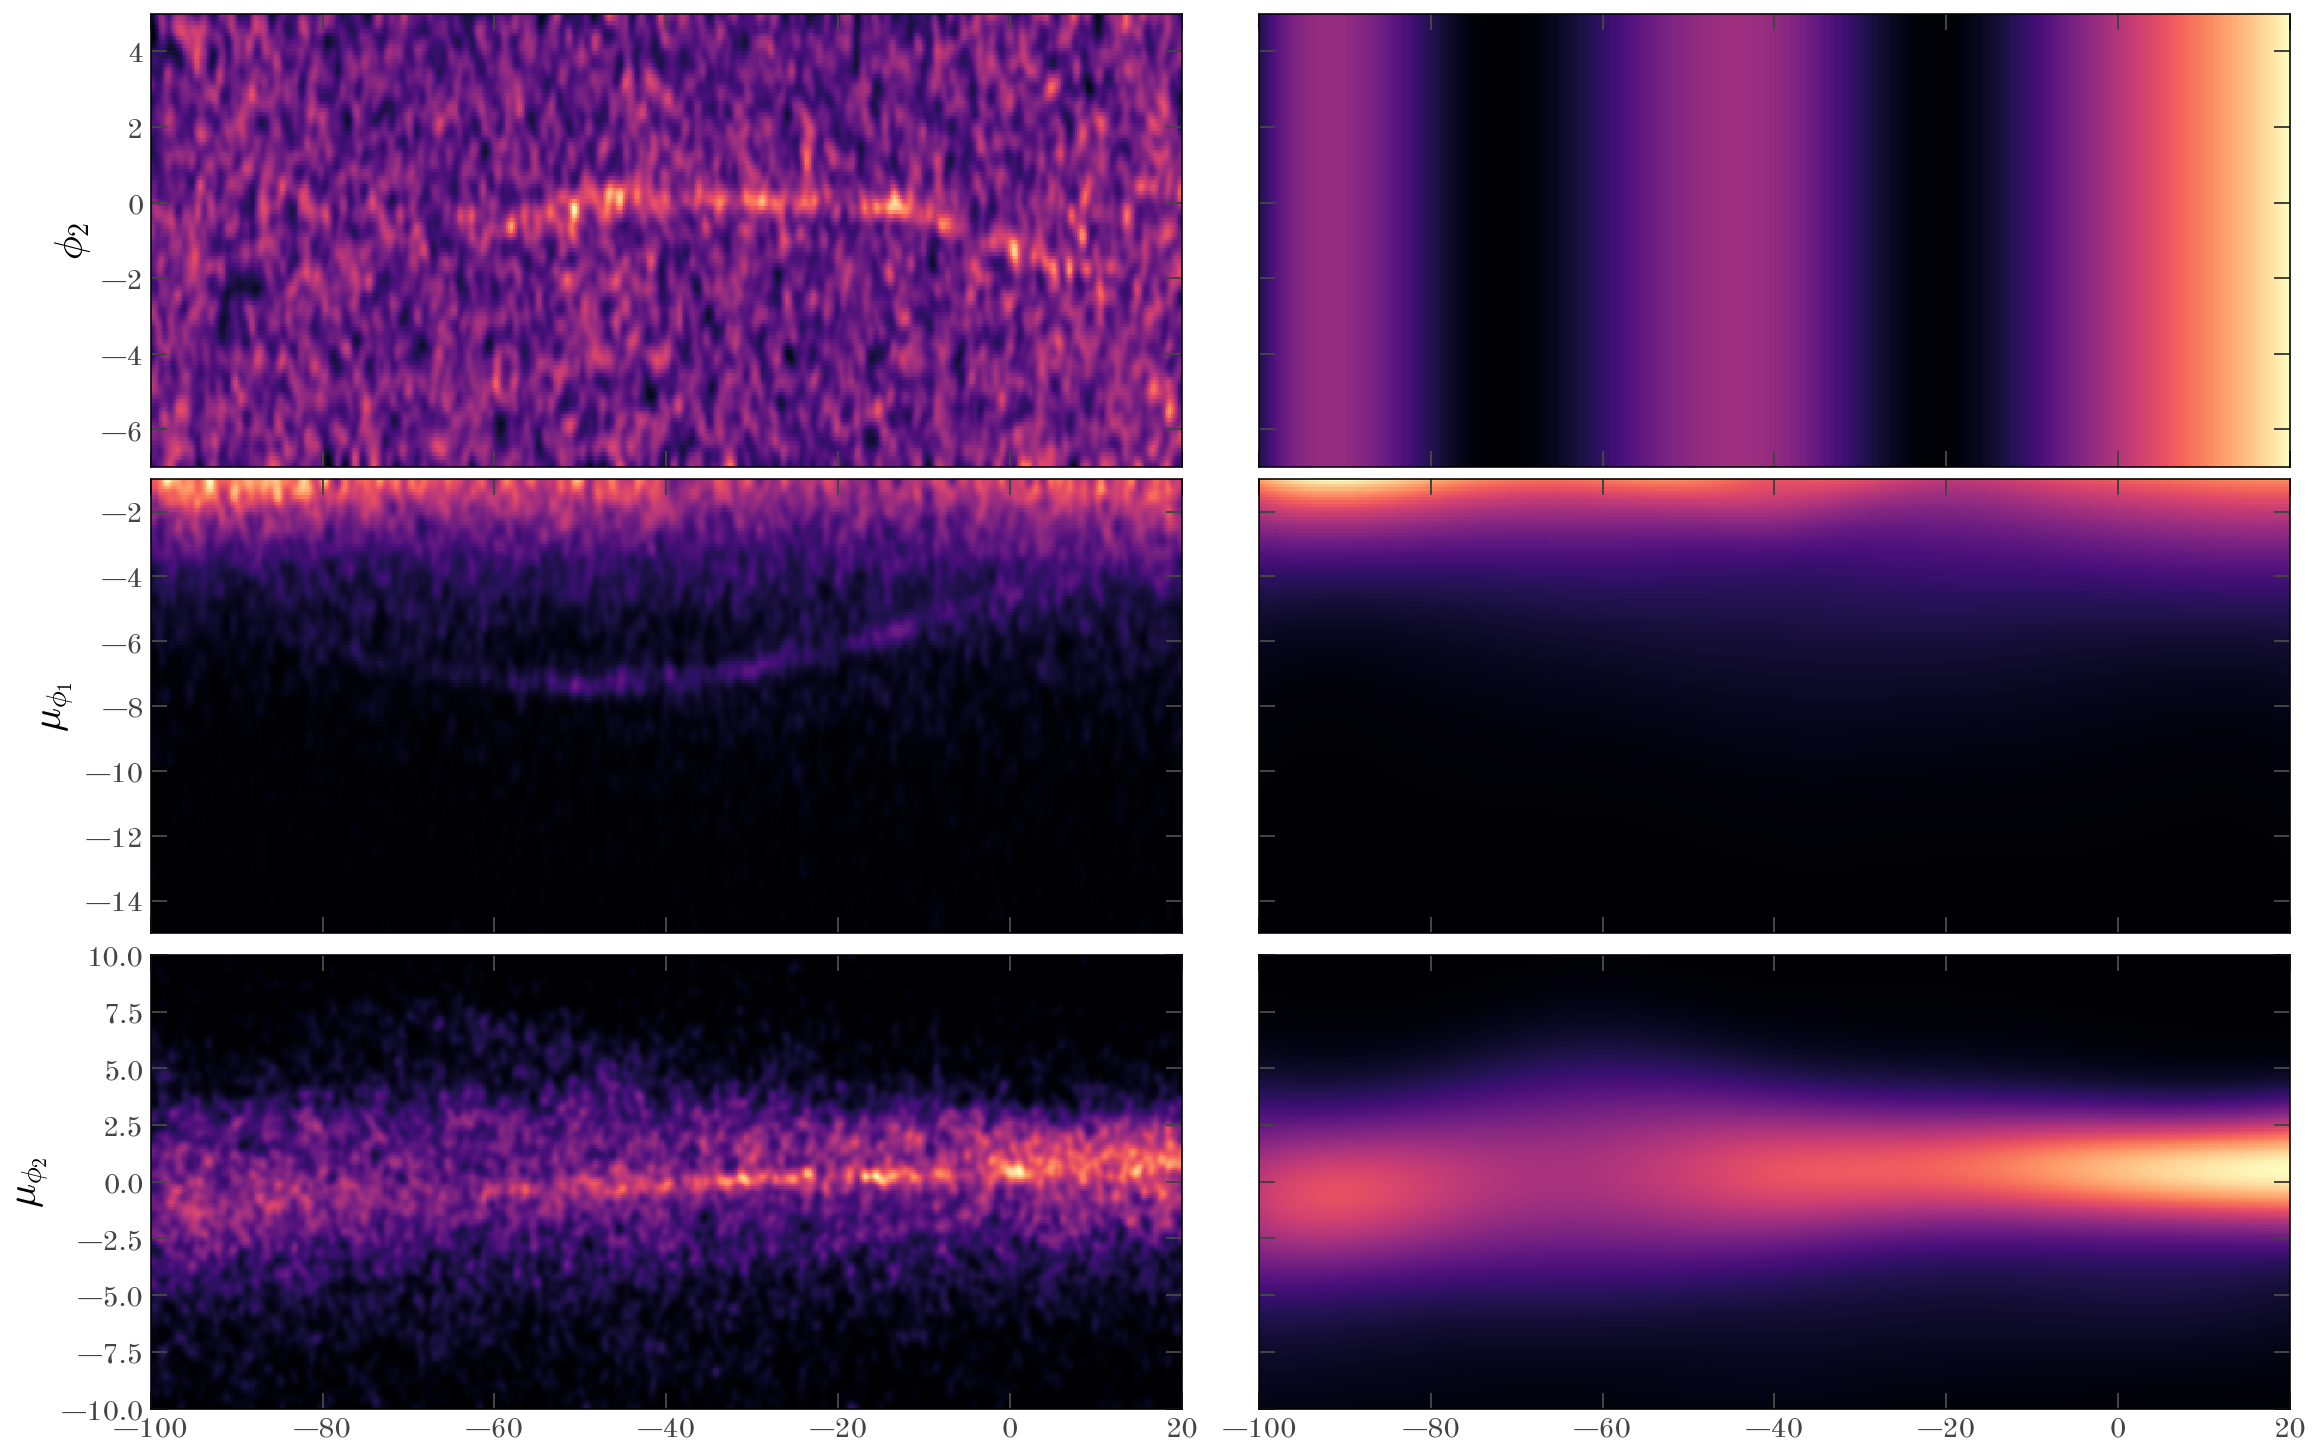

In [28]:
fig, axes = plt.subplots(
    3, 2, figsize=(16, 10), 
    sharex=True, sharey='row', constrained_layout=True
)

plot_data_projections(
    data,
    axes=axes[:, 0]
)

plot_model_projections(
    {'background': bkg_res_p}, 
    components=['background'], 
    plot_stream_knots=False,
    axes=axes[:, 1],
    label=False
);

Text(0, 0.5, '$\\mu_{\\phi_2}$')

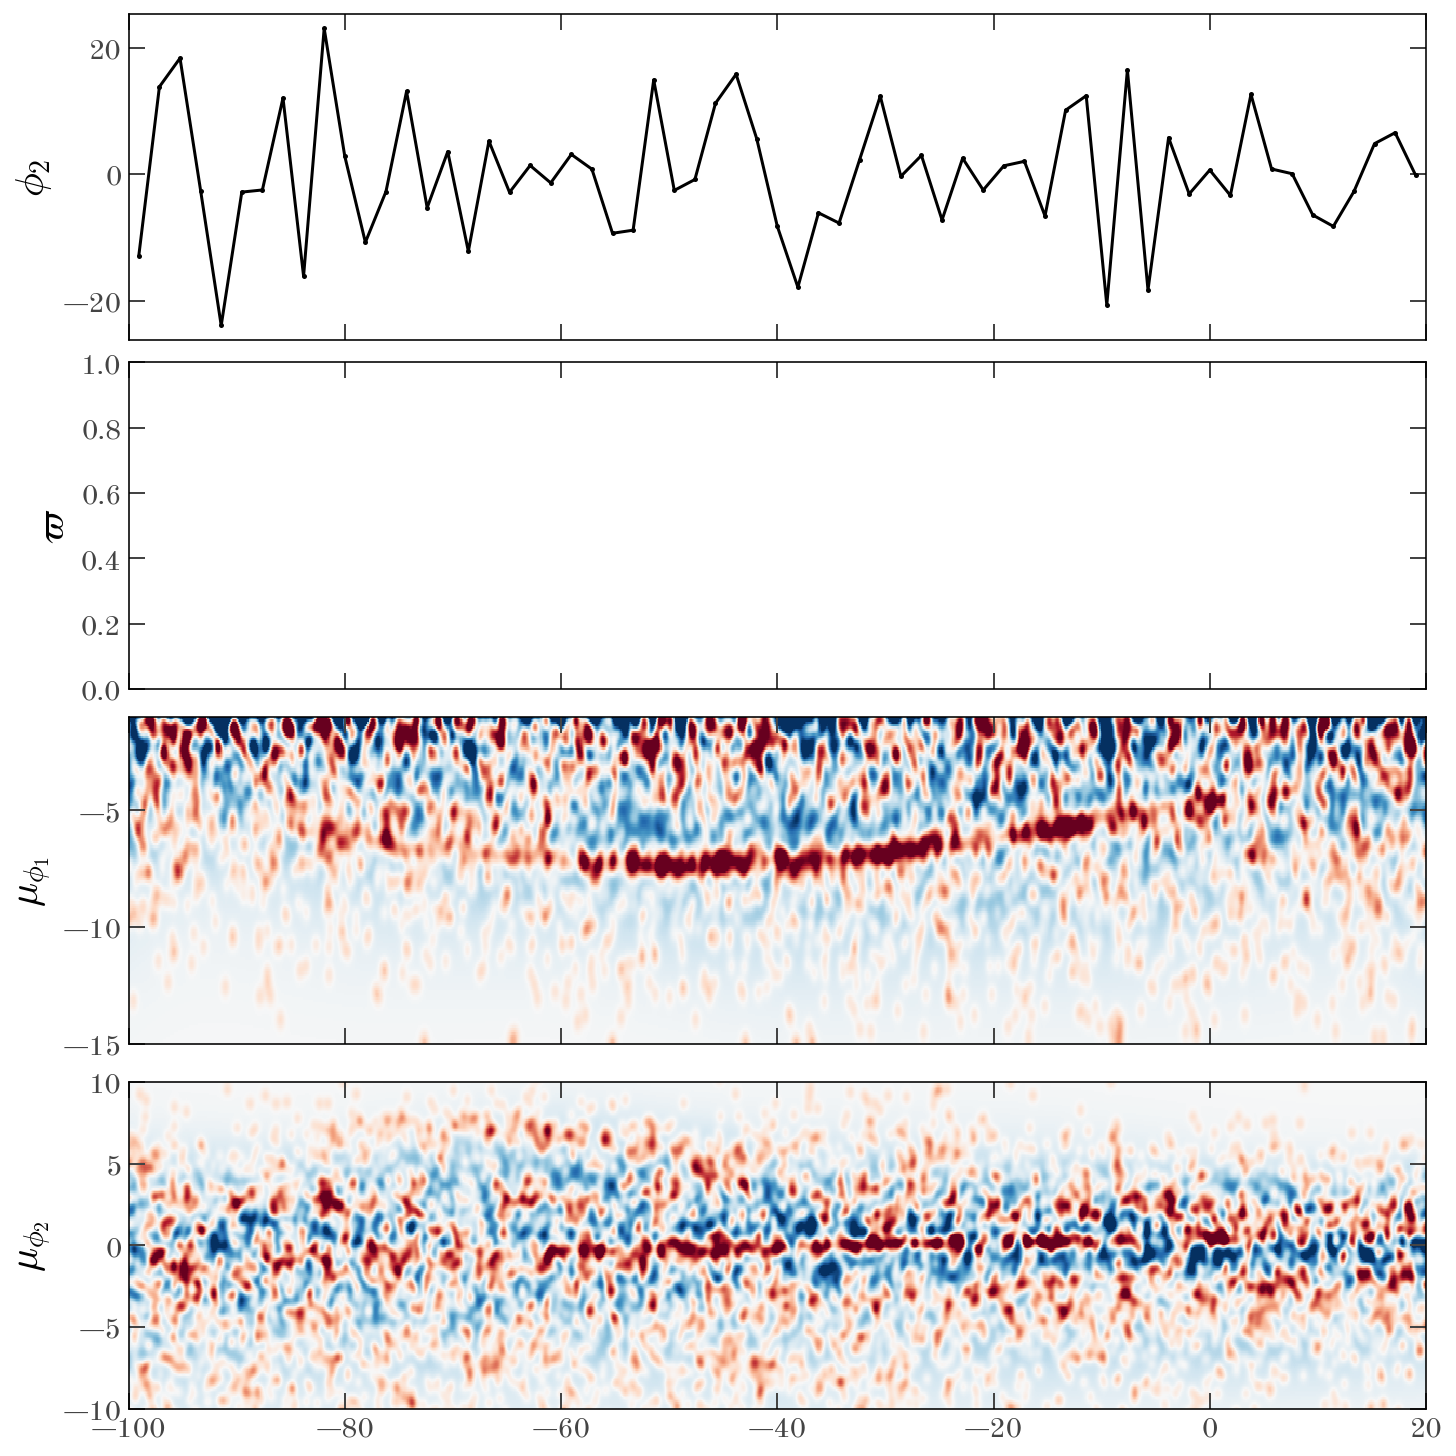

In [29]:
fig, axes = plt.subplots(
    4, 1, figsize=(10, 10), 
    sharex=True, sharey='row', constrained_layout=True
)

# phi1 density:
H, xe = np.histogram(
    c_gd1.phi1.degree[test_bkg_mask],
    bins=np.linspace(-100, 20, 64)
)
dx = xe[1] - xe[0]
xc = 0.5*(xe[:-1]+xe[1:])

plot_grid_phi1 = np.arange(-100, 20+1e-3, 0.1)
ln_n0_spl = sci.InterpolatedUnivariateSpline(
    BackgroundModel.ln_n0_knots,
    bkg_res_p['ln_n0'],
    k=3
)
axes[0].plot(xc, H / dx - np.exp(ln_n0_spl(xc)))

# pm1
plot_grid_pm1 = np.arange(-15, Model.pm1_cut[1]+1e-3, 0.1)
H_data, *_ = np.histogram2d(
    c_gd1.phi1.degree[test_bkg_mask],
    pm1[test_bkg_mask],
    bins=(plot_grid_phi1, plot_grid_pm1)
)
H_data = scn.gaussian_filter(H_data / 0.01, 3)
grid1, grid2 = np.meshgrid(
    0.5 * (plot_grid_phi1[:-1] + plot_grid_phi1[1:]), 
    0.5 * (plot_grid_pm1[:-1] + plot_grid_pm1[1:]), 
)
ln_n0 = BackgroundModel.ln_n0(grid1, bkg_res_p)
H = BackgroundModel.pm1({'phi1': grid1, 'pm1': grid2, 'pm1_error': np.zeros_like(grid1)}, bkg_res_p)
ln_dens = ln_n0 + H
axes[2].pcolormesh(grid1, grid2, H_data.T - np.exp(ln_dens), 
                   shading='auto', cmap='RdBu_r', vmin=-10, vmax=10)

# pm2
plot_grid_pm2 = np.arange(-15, 15+1e-3, 0.1)
H_data, *_ = np.histogram2d(
    c_gd1.phi1.degree[test_bkg_mask],
    pm2[test_bkg_mask],
    bins=(plot_grid_phi1, plot_grid_pm2)
)
H_data = scn.gaussian_filter(H_data / 0.01, 3)
grid1, grid2 = np.meshgrid(
    0.5 * (plot_grid_phi1[:-1] + plot_grid_phi1[1:]), 
    0.5 * (plot_grid_pm2[:-1] + plot_grid_pm2[1:]), 
)
ln_n0 = BackgroundModel.ln_n0(grid1, bkg_res_p)
H = BackgroundModel.pm2({'phi1': grid1, 'pm2': grid2, 'pm2_error': np.zeros_like(grid1)}, bkg_res_p)
ln_dens = ln_n0 + H
axes[3].pcolormesh(grid1, grid2, H_data.T - np.exp(ln_dens), 
                   shading='auto', cmap='RdBu_r', vmin=-10, vmax=10)

# ---

# axes[1, 0].set_ylim(-1, 1.1)
axes[2].set_ylim(-15, Model.pm1_cut[1])
axes[3].set_ylim(-10, 10)

axes[0].set_xlim(-100, 20)
axes[0].set_ylabel(r'$\phi_2$')
axes[1].set_ylabel(r'$\varpi$')
axes[2].set_ylabel(r'$\mu_{\phi_1}$')
axes[3].set_ylabel(r'$\mu_{\phi_2}$')

# Stream Model:

## Initialization:

In [30]:
stream_init_p = {}

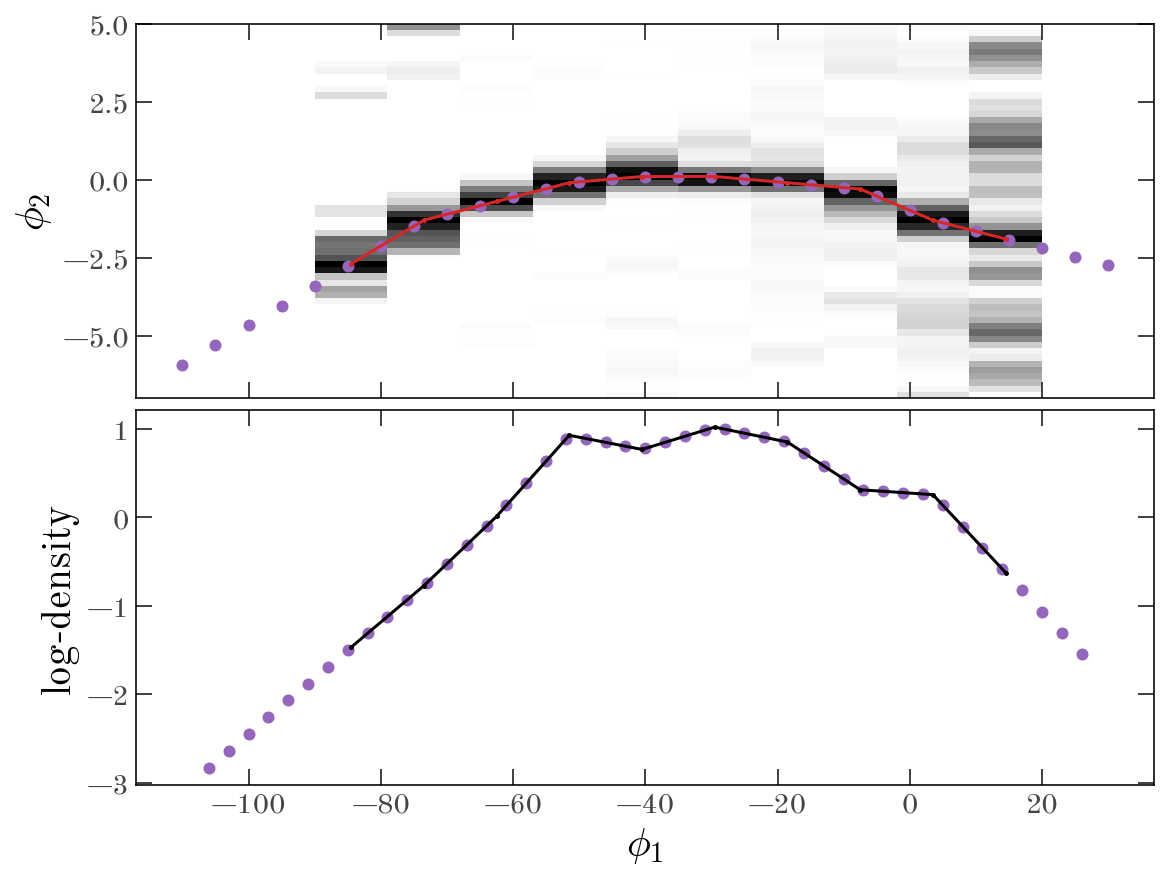

In [31]:
stream_init_mask = masks['cmd_ms'] & masks['G19.5'] & masks['pm_rough']

H, xe, ye = np.histogram2d(
    g.gd1_phi1[stream_init_mask],
    g.gd1_phi2[stream_init_mask],
    bins=(np.linspace(-90, 20 + 1e-3, 11), np.arange(-7, 5 + 1e-3, 0.2)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H -= np.mean(H[:, (yc < -5) | (yc > 3)])

H /= (xe[1] - xe[0])
H_density = H.copy()

peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]
H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
axes[0].plot(xc, yc[peak_idx], color="tab:red")
axes[0].set_ylabel(r"$\phi_2$")
axes[1].plot(xc, H_ln_density)
axes[1].set_ylabel(r"log-density")
axes[1].set_xlabel(r"$\phi_1$")

stream_init_p['ln_n0'] = sci.InterpolatedUnivariateSpline(xc, H_ln_density, k=1)(StreamModel.ln_n0_knots)
stream_init_p['mean_phi2'] = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx], k=1)(
    StreamModel.phi2_knots
)
stream_init_p["ln_std_phi2"] = np.full_like(stream_init_p['mean_phi2'], -1)

stream_ln_n0_interp_tmp = sci.InterpolatedUnivariateSpline(
    StreamModel.ln_n0_knots, 
    stream_init_p['ln_n0'],
    k=3
)
axes[0].scatter(StreamModel.phi2_knots, stream_init_p['mean_phi2'], color='tab:purple')
axes[1].scatter(StreamModel.ln_n0_knots, stream_init_p['ln_n0'], color='tab:purple')

In [32]:
stream_plot_grid_phi1_1d = np.arange(-100, 20+1e-3, 0.1)
stream_plot_grid_phi2_1d = np.arange(Model.phi2_cut[0], Model.phi2_cut[1]+1e-3, 0.1)
stream_plot_grid_phi1, stream_plot_grid_phi2 = np.meshgrid(
    stream_plot_grid_phi1_1d, stream_plot_grid_phi2_1d
)

stream_ln_sky_prob_init = StreamModel.phi2(
    {'phi1': stream_plot_grid_phi1, 'phi2': stream_plot_grid_phi2}, 
    stream_init_p
)
stream_ln_sky_init = stream_ln_sky_prob_init + StreamModel.ln_n0(stream_plot_grid_phi1, stream_init_p)

Text(0, 0.5, '$\\phi_2$')

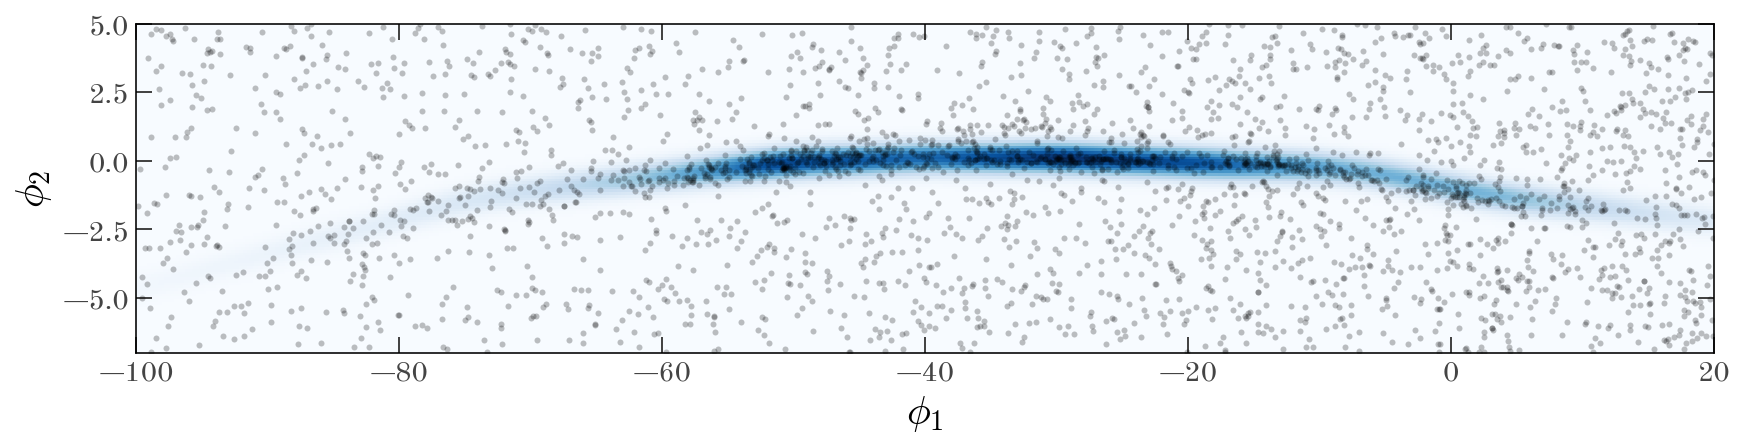

In [33]:
fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)

ax.plot(
    g.gd1_phi1[stream_init_mask],
    g.gd1_phi2[stream_init_mask],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
ax.pcolormesh(
    stream_plot_grid_phi1,
    stream_plot_grid_phi2,
    np.exp(stream_ln_sky_init),
    cmap="Blues",
    shading='auto'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

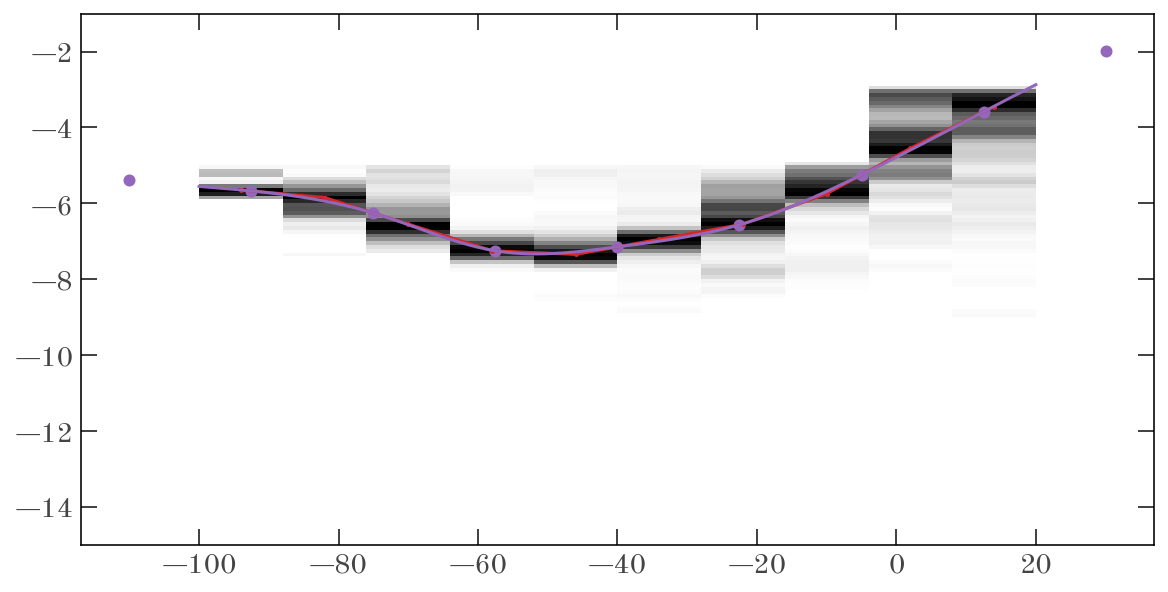

In [34]:
_mask = (
    (g.gd1_phi1 > 0) |
    ((g.gd1_phi1 <= 0) & (pm1 < -5))
)

H, xe, ye = np.histogram2d(
    g.gd1_phi1[stream_init_mask & _mask],
    pm1[stream_init_mask & _mask],
    bins=(np.linspace(-100, 20 + 1e-3, 11), np.arange(-15, Model.pm1_cut[1]+1e-3, 0.1)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H -= np.mean(H[:, (yc < -5) | (yc > 3)])
H /= (xe[1] - xe[0]) / 12
peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]

fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
cs = ax.pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
ax.plot(xc, yc[peak_idx], color="tab:red")

stream_init_p['mean_pm1'] = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx], k=1)(
    StreamModel.pm1_knots
)
stream_init_p['ln_std_pm1'] = np.full_like(StreamModel.pm1_knots, -3)

ax.scatter(StreamModel.pm1_knots, stream_init_p['mean_pm1'], color='tab:purple')
stream_pm1_interp_tmp = sci.InterpolatedUnivariateSpline(
    StreamModel.pm1_knots,
    stream_init_p['mean_pm1'],
    k=3
)
ax.plot(plot_grid_phi1, stream_pm1_interp_tmp(plot_grid_phi1), marker='', color='tab:purple')

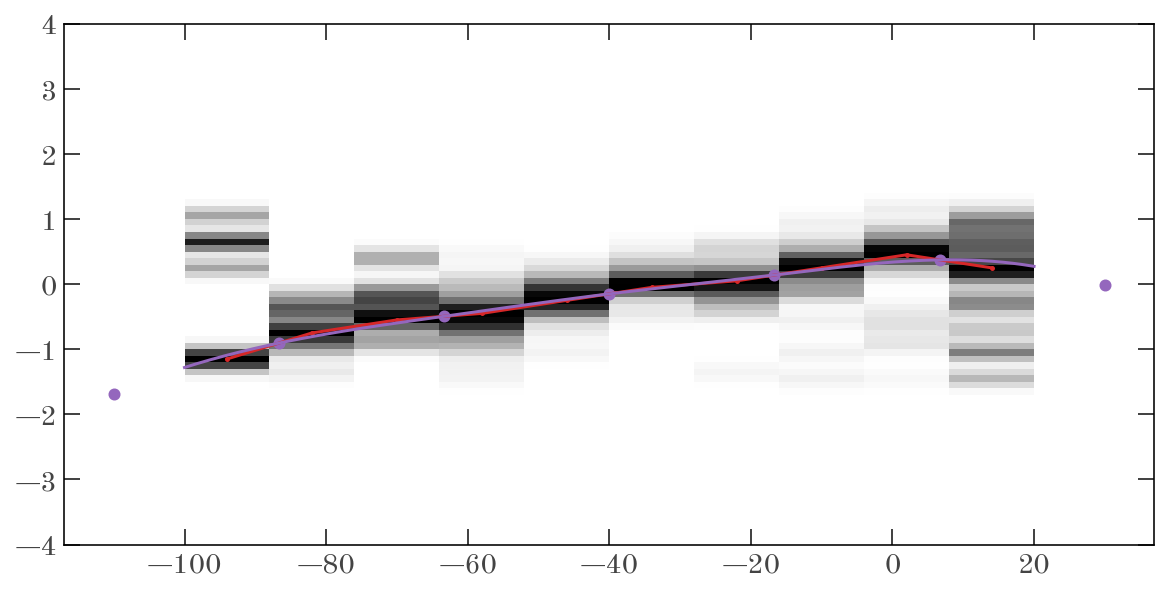

In [35]:
tmp_interp = sci.InterpolatedUnivariateSpline(
    StreamModel.pm1_knots,
    stream_init_p['mean_pm1'],
    k=3
)
_mask = np.abs(pm1 - tmp_interp(g.gd1_phi1)) < 0.1

H, xe, ye = np.histogram2d(
    g.gd1_phi1[stream_init_mask & _mask],
    pm2[stream_init_mask & _mask],
    bins=(np.linspace(-100, 20 + 1e-3, 11), np.arange(-4, 4+1e-3, 0.1)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H -= np.mean(H[:, (yc < -5) | (yc > 3)])
H /= (xe[1] - xe[0]) / 12
peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]

fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
cs = ax.pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
ax.plot(xc, yc[peak_idx], color="tab:red")

stream_init_p['mean_pm2'] = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx], k=1)(
    StreamModel.pm2_knots
)
stream_init_p['ln_std_pm2'] = np.full_like(StreamModel.pm2_knots, -3)

ax.scatter(StreamModel.pm2_knots, stream_init_p['mean_pm2'], color='tab:purple')
stream_pm2_interp_tmp = sci.InterpolatedUnivariateSpline(
    StreamModel.pm2_knots,
    stream_init_p['mean_pm2'],
    k=3
)
ax.plot(plot_grid_phi1, stream_pm2_interp_tmp(plot_grid_phi1), marker='', color='tab:purple')

# Spur Model

In [36]:
spur_init_p = {}
spur_box = (
    (c_gd1.phi1 > -60 * u.deg) &
    (c_gd1.phi1 < 0 * u.deg) &
    (c_gd1.phi2 > -4 * u.deg) &
    (c_gd1.phi2 < 4 * u.deg)
)
spur_init_mask = masks['cmd_ms'] & masks['pm_rough'] & spur_box & (g.parallax < 0.5*u.mas)

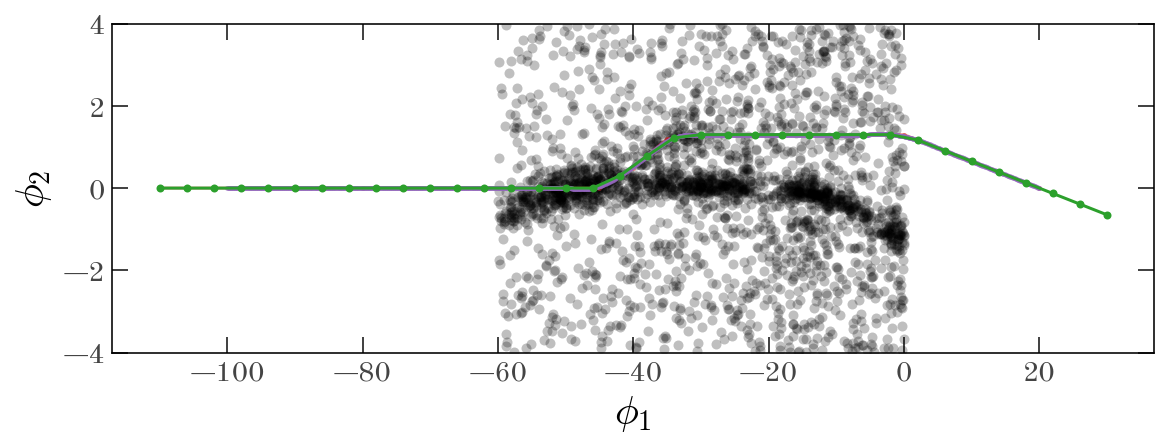

In [37]:
spur_sky_nodes_tmp = np.array([
    [-110, 0],
    [-80, 0],
    [-50, 0],
    [-45, 0],
    [-40, 0.5],
    [-35, 1.2],
    [-30, 1.3],
    [-25, 1.3],
    [-20, 1.3],
    [0, 1.3],
    [20, 0.]
])

fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)

ax.plot(
    g.gd1_phi1[spur_init_mask],
    g.gd1_phi2[spur_init_mask],
    marker="o",
    markeredgewidth=0,
    markersize=5,
    ls="none",
    alpha=0.25,
)

# ax.plot(spur_sky_nodes_tmp[:, 0], spur_sky_nodes_tmp[:, 1], color='tab:purple', alpha=0.5)

# ax.set_xlim()
ax.set_ylim(-4, 4)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

spur_init_p['mean_phi2'] = sci.InterpolatedUnivariateSpline(
    spur_sky_nodes_tmp[:, 0], 
    spur_sky_nodes_tmp[:, 1],
    k=1
)(SpurModel.phi2_knots)
spur_init_p['ln_std_phi2'] = np.full_like(spur_init_p['mean_phi2'], -0.75)
ax.plot(
    spur_sky_nodes_tmp[:, 0], 
    spur_sky_nodes_tmp[:, 1],
    color='tab:red', alpha=0.5
)
ax.plot(
    SpurModel.phi2_knots,
    spur_init_p['mean_phi2'], 
    color='tab:green', 
    zorder=100,
    marker='o', ms=4
)

tmp = sci.InterpolatedUnivariateSpline(
    SpurModel.phi2_knots,
    spur_init_p['mean_phi2'],
    k=3
)
ax.plot(plot_grid_phi1, tmp(plot_grid_phi1), color='tab:purple', alpha=0.5)
# ax.plot(SpurModel.phi2_knots, run_res_pars['spur']['mean_phi2'])

In [38]:
spur_init_p['ln_n0'] = stream_ln_n0_interp_tmp(SpurModel.ln_n0_knots) - 1.
spur_init_p['ln_n0'] = np.clip(
    spur_init_p['ln_n0'] 
    + jax.nn.log_sigmoid((SpurModel.ln_n0_knots - -50) / 1.) 
    + jax.nn.log_sigmoid((-SpurModel.ln_n0_knots - 20) / 1.),
    a_min=-8,
    a_max=None
)
spur_init_p['ln_n0']

DeviceArray([-8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
             -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
             -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
             -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
             -8.00000000e+00, -8.00000000e+00, -4.28777945e+00,
             -7.87466700e-01, -1.72218789e-01, -2.13201059e-01,
             -1.81347039e-01, -8.49973116e-02, -4.42404117e-03,
             -3.51512316e-02, -2.23672016e-01, -2.30496264e+00,
             -6.37369880e+00, -8.00000000e+00, -8.00000000e+00,
             -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
             -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
             -8.00000000e+00, -8.00000000e+00, -8.00000000e+00],            dtype=float64)

In [39]:
for k in SpurModel.param_names:
    assert k in spur_init_p

# Joint model:

In [40]:
run_mask = masks['cmd_ms'] & masks['pm1_cut']

run_data = {
    'phi1': c_gd1.phi1.degree[run_mask],
    'phi2': c_gd1.phi2.degree[run_mask],
    'pm1': pm1[run_mask],
    'pm1_error': pm1_err[run_mask],
    'pm2': pm2[run_mask],
    'pm2_error': pm2_err[run_mask],
}
at.Table(run_data).write(cache_path / 'run_data.fits', overwrite=True);

In [41]:
# test round-tripping:
# wtf = {StreamModel.name: stream_init_p, BackgroundModel.name: bkg_init_p}
# JointModel.unpack_component_pars(JointModel.pack_component_pars(wtf))

In [42]:
init_pars = {
    StreamModel.name: stream_init_p, 
    BackgroundModel.name: bkg_init_p,
    SpurModel.name: spur_init_p
}

flat_init_pars = JointModel.pack_component_pars(init_pars)
flat_init_p = JointModel.pack_pars(flat_init_pars)
flat_init_p.size

322

In [43]:
JointModel.ln_likelihood(flat_init_pars, run_data)

(DeviceArray(9.56790857, dtype=float64),
 DeviceArray([-2.56104554, -1.41964607, -1.11252272, ..., -1.94502382,
              -1.89733482, -1.19889588], dtype=float64))

In [44]:
JointModel.ln_prior(flat_init_pars)

DeviceArray(-1143.46249518, dtype=float64)

In [45]:
JointModel.objective(flat_init_p, run_mask.sum(), run_data)

DeviceArray(2.23659046, dtype=float64)

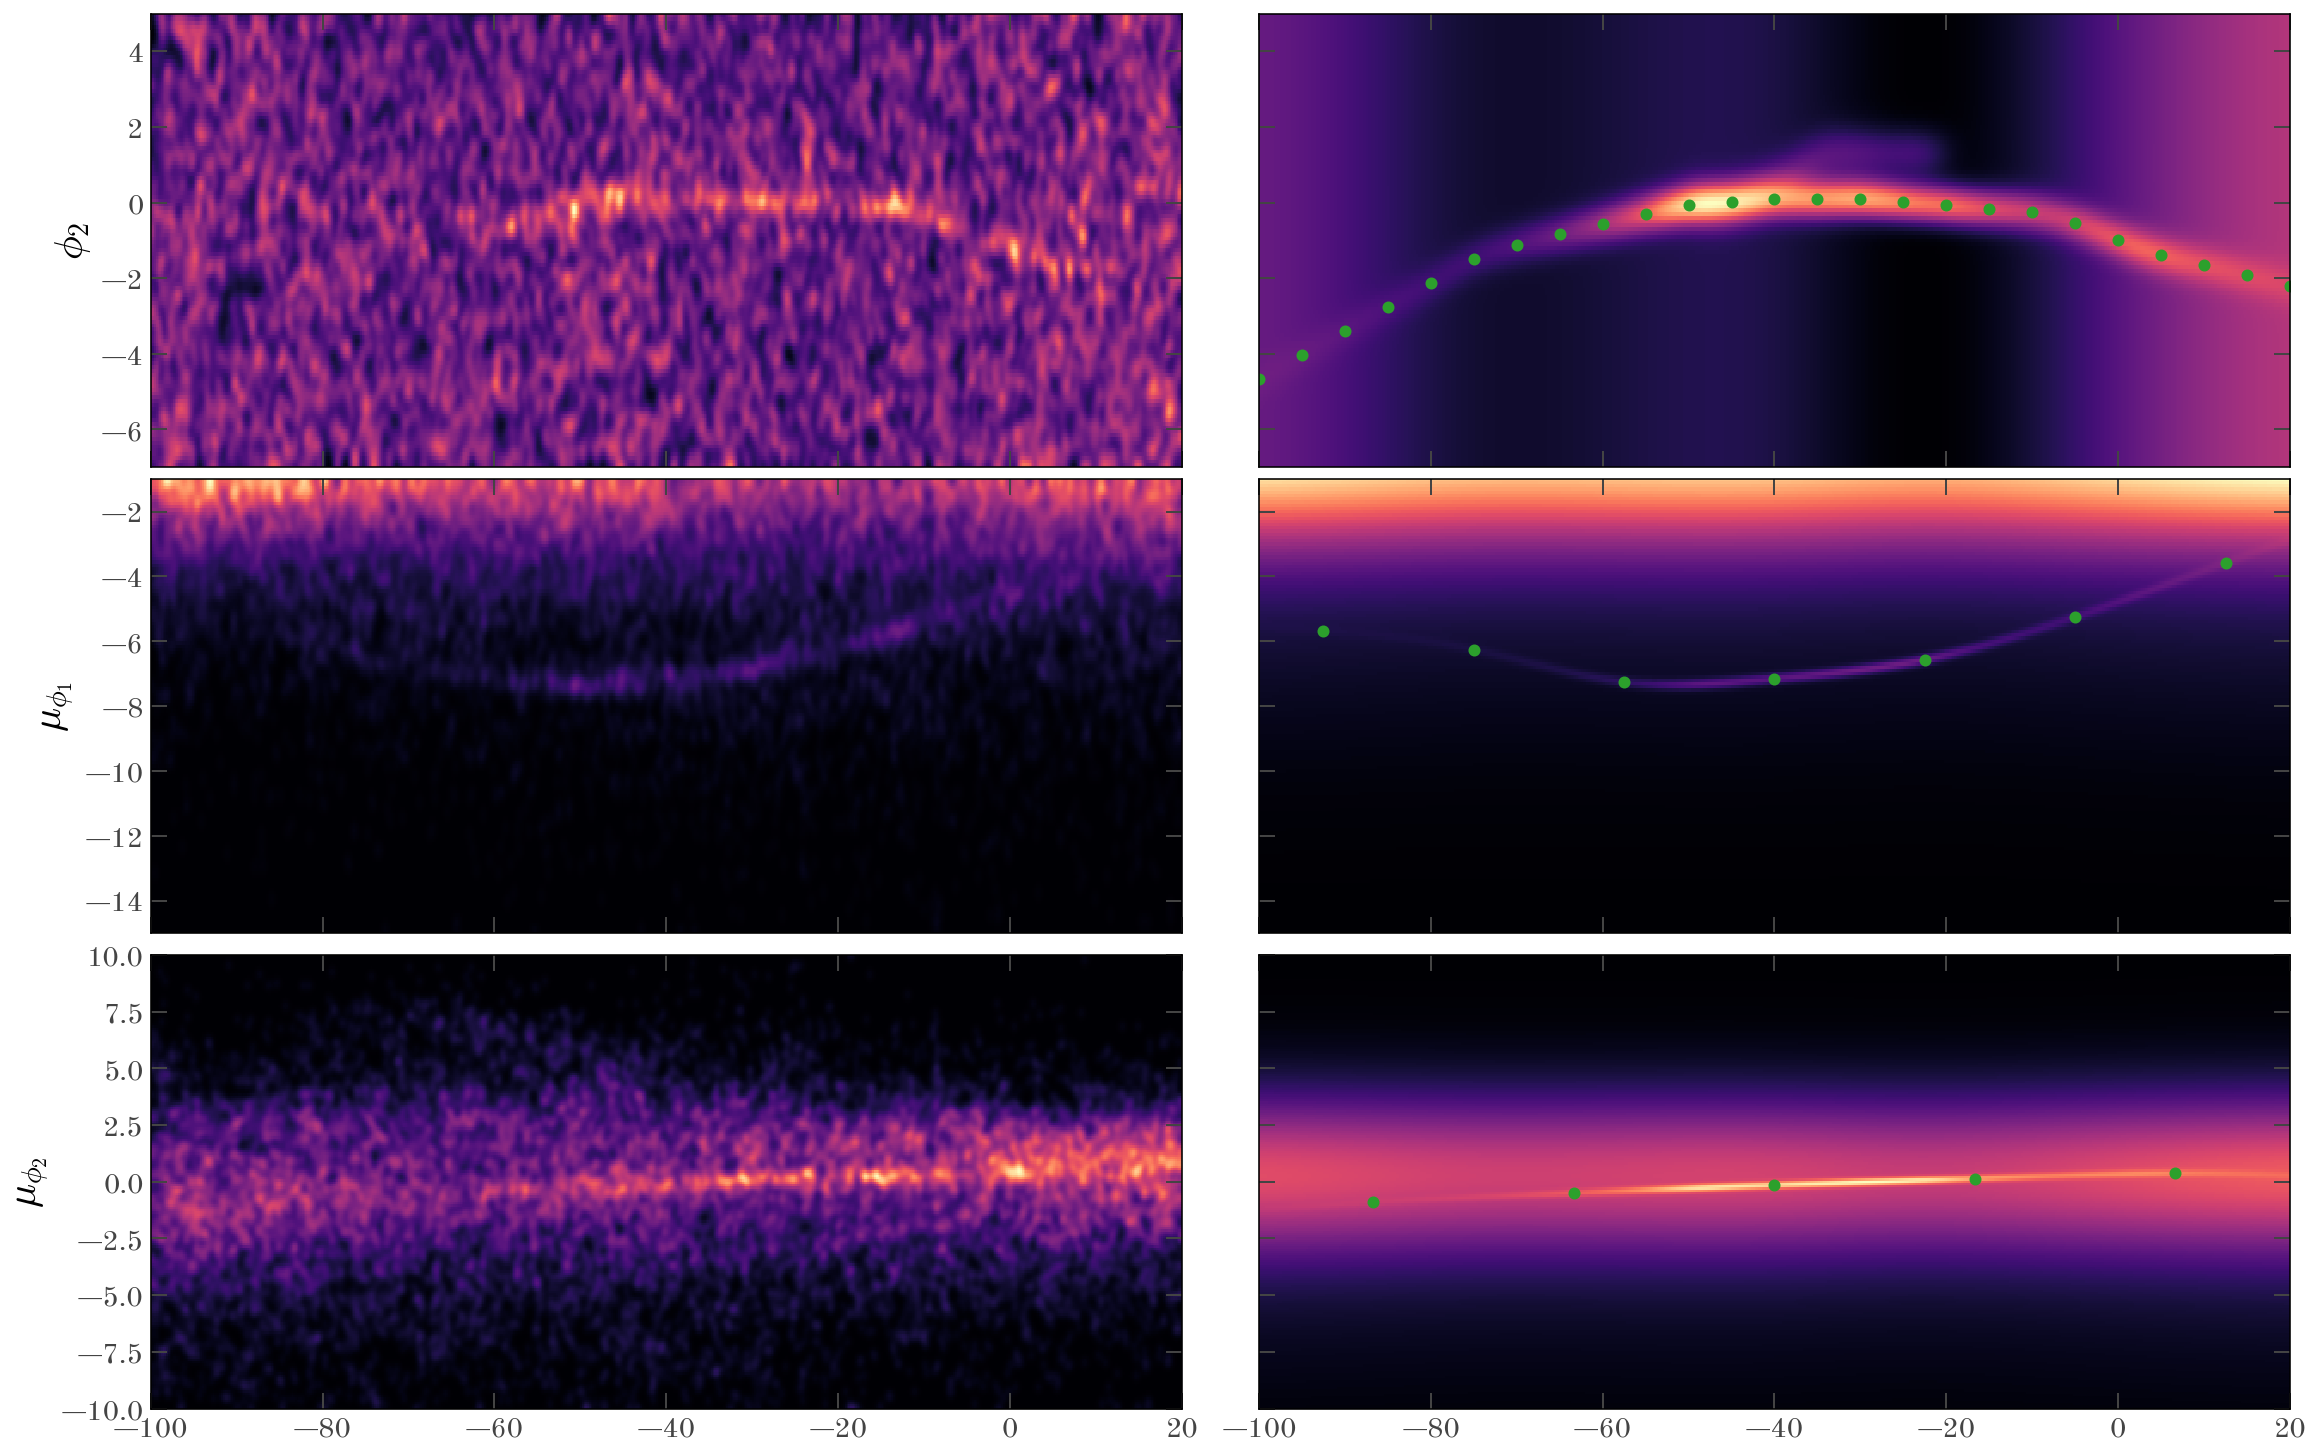

In [46]:
fig, axes = plt.subplots(
    3, 2, figsize=(16, 10), 
    sharex=True, sharey='row', constrained_layout=True
)

plot_data_projections(
    data,
    axes=axes[:, 0]
)

init_pars_unpacked = JointModel.unpack_component_pars(JointModel.unpack_pars(flat_init_p))
plot_model_projections(
    init_pars_unpacked,
    plot_stream_knots=True,
    axes=axes[:, 1],
    label=False
);

In [47]:
# run_res = sco.minimize(
#     jax.value_and_grad(JointModel.objective),
#     flat_init_p,
#     args=(run_mask.sum(), run_data),
#     jac=True,
#     method="bfgs",
#     options=dict(maxiter=100_000, maxls=1000),
# )
# print(run_res)

# run_res_pars = JointModel.unpack_component_pars(JointModel.unpack_pars(run_res.x))
# run_res_pars

In [48]:
param_bounds = {}
for Component in JointModel.components.values():
    for k, v in Component.param_bounds.items():
        param_bounds[f'{k}_{Component.name}'] = v

_tmp_l = JointModel.pack_pars(
    {k: np.full(JointModel.param_names[k], v[0], dtype='f8') 
     for k, v in param_bounds.items() if k in JointModel.param_names}
)
_tmp_r = JointModel.pack_pars(
    {k: np.full(JointModel.param_names[k], v[1], dtype='f8')
    for k, v in param_bounds.items() if k in JointModel.param_names}
)
bounds = np.stack((_tmp_l, _tmp_r)).T
assert bounds.shape[0] == flat_init_p.shape[0]

Check that all initial paramter values are in bounds

In [49]:
for k in JointModel.param_names:
    check = (
        (flat_init_pars[k] >= param_bounds[k][0]) &
        (flat_init_pars[k] <= param_bounds[k][1])
    )
    if not np.all(check):
        print(k, flat_init_pars[k])

## Run optimizer

In [50]:
obj_grad = jax.jit(jax.grad(JointModel.objective))
run_res = sco.minimize(
    JointModel.objective, 
    x0=flat_init_p,
    jac=lambda x, *args: np.array(obj_grad(x, *args)),
    method='l-bfgs-b',
    bounds=bounds,
    args=(run_mask.sum(), run_data),
    options=dict(maxiter=100_000, maxls=1000)
)
run_res.success

True

In [67]:
run_res

      fun: 1.6770689324486638
 hess_inv: <322x322 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.54738308e-07,  5.60019458e-08,  3.92205957e-08, -1.22248542e-07,
       -5.13332579e-08,  2.77263534e-09,  1.25622112e-07,  1.50164175e-07,
        7.82337164e-07,  2.96776743e-06,  2.29047597e-05, -6.66726288e-06,
        1.13799076e-05,  5.34530183e-08,  1.68355970e-05,  2.04196349e-06,
       -9.60582207e-07, -1.93094151e-05, -4.53095687e-06, -2.39596355e-06,
        2.68492537e-06, -1.16435610e-05, -3.58168382e-06, -7.99467458e-07,
       -7.12980823e-07, -4.10047218e-06, -4.23375704e-06, -1.38873961e-05,
       -8.68419246e-06, -1.95041236e-06, -1.87071333e-06, -3.11555109e-05,
        4.43684784e-06,  1.36348679e-06, -2.80193364e-06, -1.57168553e-05,
       -1.75335175e-06, -2.37593090e-06, -9.32405094e-06, -7.77204114e-06,
        4.17889900e-06, -3.35863469e-06,  5.39041159e-06,  3.39149228e-07,
       -1.17611160e-05, -8.72928872e-05,  8.56234324e-05,  1.38146926e-05,

In [51]:
run_res_pars = JointModel.unpack_component_pars(JointModel.unpack_pars(run_res.x))

In [52]:
run_res_pars['background']

{'ln_n0': DeviceArray([6.64354593, 5.88653592, 5.72288822, 5.66500954, 5.72202111,
              5.76504356, 5.91464002, 6.13520205, 6.26629161],            dtype=float64),
 'ln_std1_pm1': DeviceArray([1.73572656, 1.65374168, 1.69570732, 1.61621153, 1.64686583,
              1.8119442 , 1.46818928], dtype=float64),
 'ln_std1_pm2': DeviceArray([1.38793486, 0.82836053, 1.19011646, 0.9364598 , 0.63911721,
              0.45357766, 0.48571209], dtype=float64),
 'ln_std2_pm1': DeviceArray([1.77096631, 2.03851844, 1.82453411, 2.01859995, 1.92897962,
              1.9664496 , 2.37056371], dtype=float64),
 'ln_std2_pm2': DeviceArray([1.80010481, 1.38121503, 1.5450218 , 1.33642316, 1.24333511,
              1.11125545, 1.43667591], dtype=float64),
 'mean1_pm1': DeviceArray([20.        , 20.        , 20.        , 19.44207511,
              19.61106014, 20.        , 20.        ], dtype=float64),
 'mean1_pm2': DeviceArray([ 0.57032554, -0.06669866,  0.76960592,  0.79109543,
               0.708738

In [53]:
run_res_pars['stream']

{'ln_n0': DeviceArray([-2.86244562, -2.35450218, -6.2420448 , -0.36792651,
              -8.        , -2.74844971, -0.91492648,  1.34936297,
               1.97805324,  1.83734614,  2.214398  ,  2.17946909,
               1.91375133,  1.99660758,  2.17672022,  2.62012423,
               2.85814754,  3.03378728,  3.58611787,  3.54586201,
               3.51658207,  2.93436027,  2.35727274,  2.77885865,
               2.67592873,  3.11032997,  3.08406302,  3.01669431,
               1.94801418,  2.0348189 ,  3.24845786,  3.37319946,
               2.79081995,  2.57009126,  2.24374639,  3.47823712,
               2.89732203,  1.55909217,  2.25589635,  1.95257639,
               2.07272539,  0.8219648 ,  1.51351292,  2.13270873,
              -1.97542595], dtype=float64),
 'ln_std_phi2': DeviceArray([-0.77799213, -0.88256265, -1.2327987 , -1.34955173,
              -1.34083655, -1.34358718, -0.91007048, -0.65201251,
              -0.80474121, -0.82760693, -1.22772462, -1.27542185,
        

In [54]:
run_res_pars['spur']

{'ln_n0': DeviceArray([-8.        , -8.        , -8.        , -8.        ,
              -8.        , -8.        , -8.        , -8.        ,
              -8.        , -8.        , -8.        , -8.        ,
              -8.        , -8.        , -8.        , -8.        ,
              -8.        ,  1.08482468,  1.99410163,  2.39109284,
               1.94539915,  0.59652457,  0.53224098, -8.        ,
              -8.        , -8.        , -8.        , -8.        ,
              -8.        , -8.        , -8.        , -8.        ,
              -8.        , -8.        , -8.        , -8.        ],            dtype=float64),
 'ln_std_phi2': DeviceArray([-0.70738607, -0.70600986, -0.70515887, -0.70229915,
              -0.69938376, -0.6973983 , -0.69447062, -0.69482775,
              -0.69816385, -0.70001532, -0.70269523, -0.70636224,
              -0.70974583, -0.71275882, -0.71449687, -0.71236275,
              -0.71713315, -0.69697672, -0.87932083, -0.92804435,
              -0.8914243

In [55]:
# grid1, grid2 = np.meshgrid(plot_grids['phi1'], plot_grids['phi2'])
# str_ln_dens = (
#     StreamModel.phi2({'phi1': grid1, 'phi2': grid2}, run_res_pars['stream'])
#     + StreamModel.ln_n0(grid1, run_res_pars['stream'])
# )
# spur_ln_dens = np.array(
#     SpurModel.phi2({'phi1': grid1, 'phi2': grid2}, run_res_pars['spur'])
#     + SpurModel.ln_n0(grid1, run_res_pars['spur'])
# )
# fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
# axes[0].pcolormesh(grid1, grid2, np.exp(str_ln_dens) + np.exp(spur_ln_dens), shading='auto')
# axes[1].pcolormesh(grid1, grid2, np.exp(spur_ln_dens), shading='auto')

# # ---

# grid1, grid2 = np.meshgrid(plot_grids['phi1'], plot_grids['pm1'])
# str_ln_dens = (
#     StreamModel.pm1({'phi1': grid1, 'pm1': grid2, 'pm1_error': np.zeros_like(grid2)}, 
#                     run_res_pars['stream'])
#     + StreamModel.ln_n0(grid1, run_res_pars['stream'])
# )
# spur_ln_dens = np.array(
#     SpurModel.pm1({'phi1': grid1, 'pm1': grid2, 'pm1_error': np.zeros_like(grid2)}, 
#                   run_res_pars['spur'])
#     + SpurModel.ln_n0(grid1, run_res_pars['spur'])
# )
# fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
# axes[0].pcolormesh(grid1, grid2, np.exp(str_ln_dens) + np.exp(spur_ln_dens), shading='auto')
# axes[1].pcolormesh(grid1, grid2, np.exp(spur_ln_dens), shading='auto')
# for ax in axes:
#     ax.set_ylim(-15, Model.pm1_cut[1])
    
# # ---

# grid1, grid2 = np.meshgrid(plot_grids['phi1'], plot_grids['pm2'])
# str_ln_dens = (
#     StreamModel.pm2({'phi1': grid1, 'pm2': grid2, 'pm2_error': np.zeros_like(grid2)}, 
#                     run_res_pars['stream'])
#     + StreamModel.ln_n0(grid1, run_res_pars['stream'])
# )
# spur_ln_dens = np.array(
#     SpurModel.pm2({'phi1': grid1, 'pm2': grid2, 'pm2_error': np.zeros_like(grid2)}, 
#                   run_res_pars['spur'])
#     + SpurModel.ln_n0(grid1, run_res_pars['spur'])
# )
# fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
# axes[0].pcolormesh(grid1, grid2, np.exp(str_ln_dens) + np.exp(spur_ln_dens), shading='auto')
# axes[1].pcolormesh(grid1, grid2, np.exp(spur_ln_dens), shading='auto')
# for ax in axes:
#     ax.set_ylim(-5, 5)

## Plot results

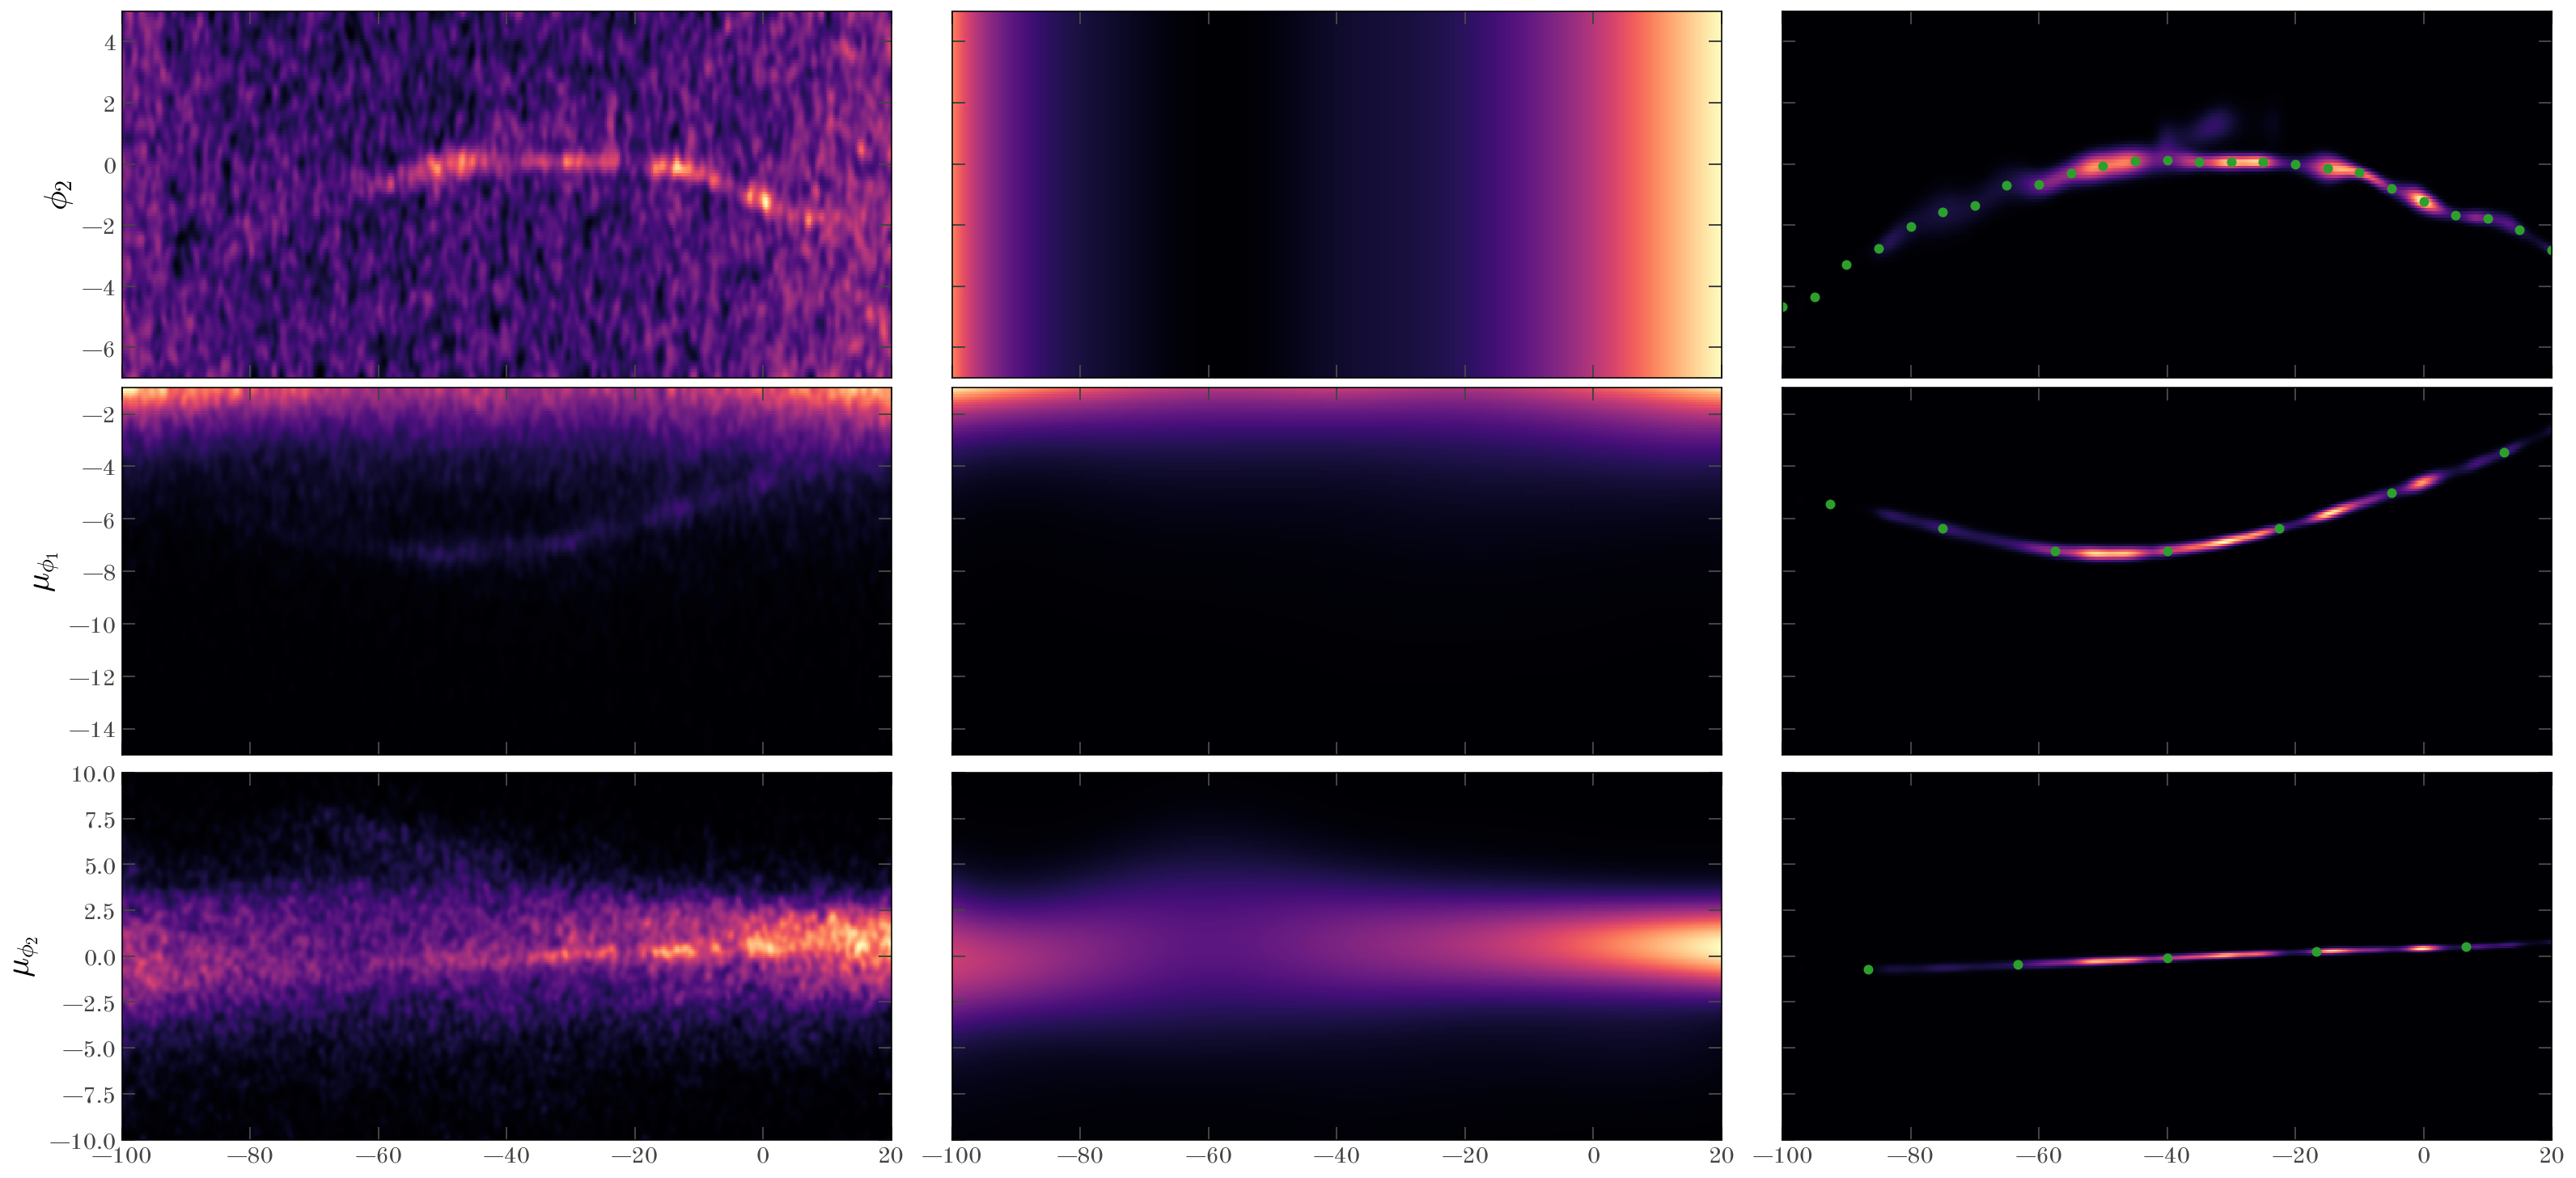

In [56]:
fig, axes = plt.subplots(3, 3, figsize=(22, 10), 
                         sharex=True, sharey='row', constrained_layout=True)

plot_data_projections(run_data, axes=axes[:, 0])
plot_model_projections(run_res_pars, axes=axes[:, 1], label=False, 
                       components=['background'], plot_stream_knots=False);
plot_model_projections(run_res_pars, axes=axes[:, 2], label=False, 
                       components=['stream', 'spur']);

## Post-processing

Compute stream probability membership:

In [57]:
ll_bg = BackgroundModel.ln_likelihood(run_res_pars['background'], all_data)[1]

In [58]:
ll_fg = np.logaddexp(
    StreamModel.ln_likelihood(run_res_pars['stream'], all_data)[1],
    SpurModel.ln_likelihood(run_res_pars['spur'], all_data)[1]
)

/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_16818/4089132475.py:1: RuntimeWarning: invalid value encountered in subtract
  post_prob = np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))


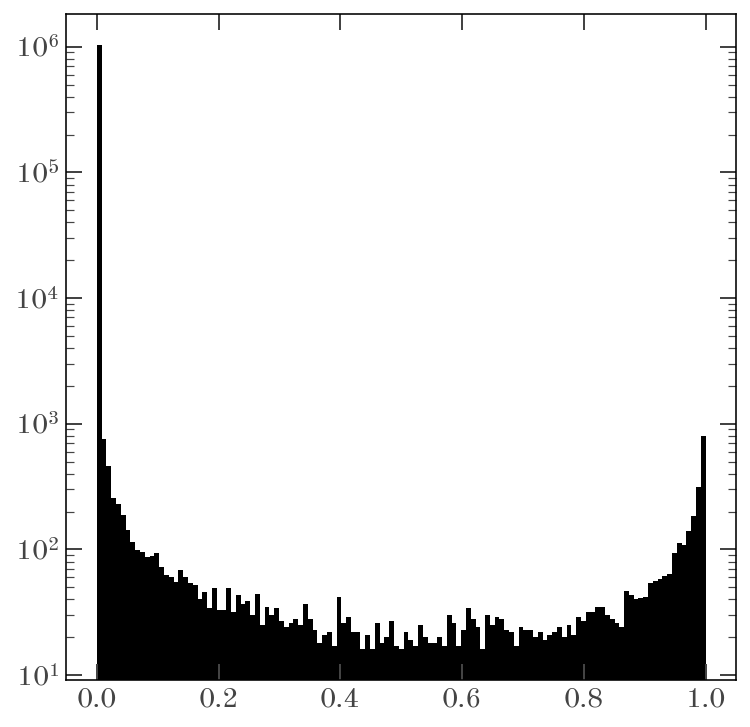

In [59]:
post_prob = np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
at.Table({'source_id': g.source_id, 'member_prob': post_prob}).write(
    cache_path / 'optimized-member-prob.fits',
    overwrite=True
)

plt.hist(post_prob[np.isfinite(post_prob)], bins=np.linspace(0, 1, 128));
plt.yscale('log')

Cache optimized parameters and model, do sampling in new notebook

In [60]:
with open(cache_path / 'joint-model.pkl', 'wb') as f:
    pickle.dump((JointModel, run_res_pars), f)

# Visualize high probability members

Text(0, 0.5, '$\\phi_2$')

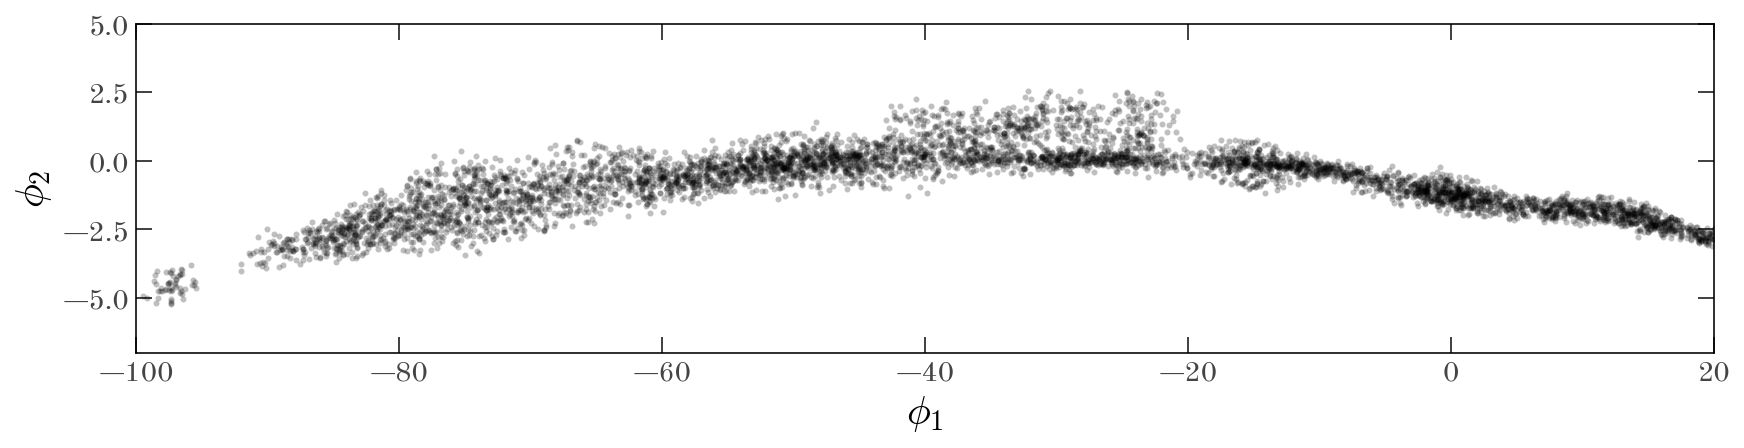

In [61]:
prob_mask = post_prob > 0.05
# prob_mask = (post_prob > 0.1) & (post_prob < 0.9)

fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)

ax.plot(
    g.gd1_phi1[prob_mask],
    g.gd1_phi2[prob_mask],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

Text(0, 0.5, '$\\phi_2$')

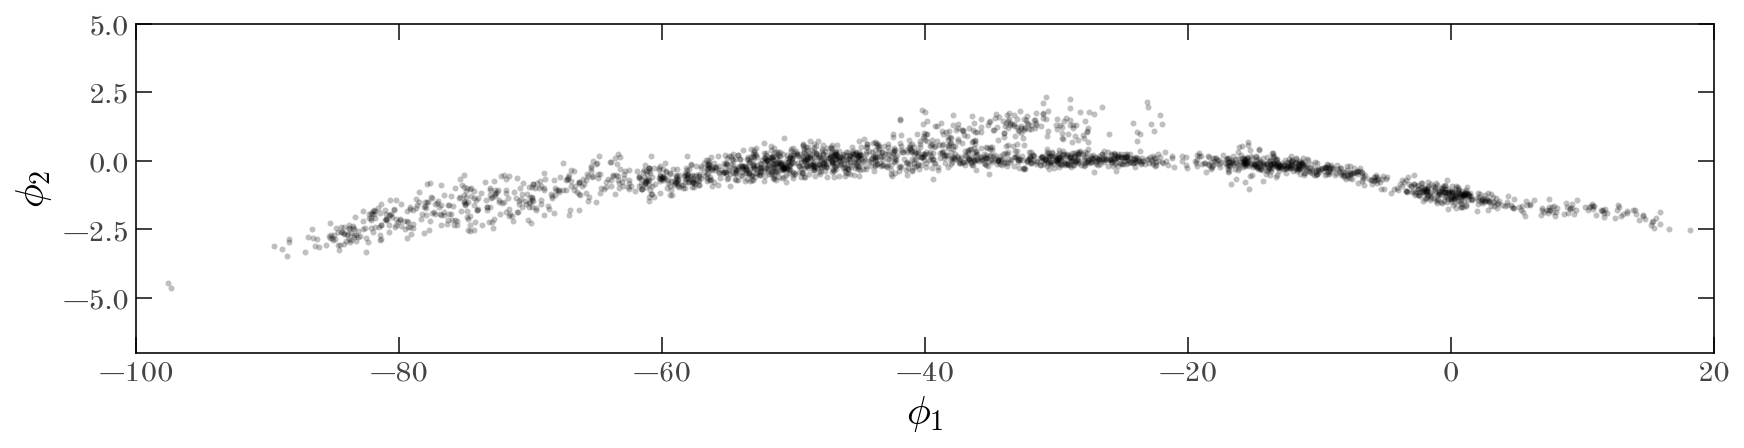

In [62]:
prob_mask = post_prob > 0.8

fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)

ax.plot(
    g.gd1_phi1[prob_mask],
    g.gd1_phi2[prob_mask],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

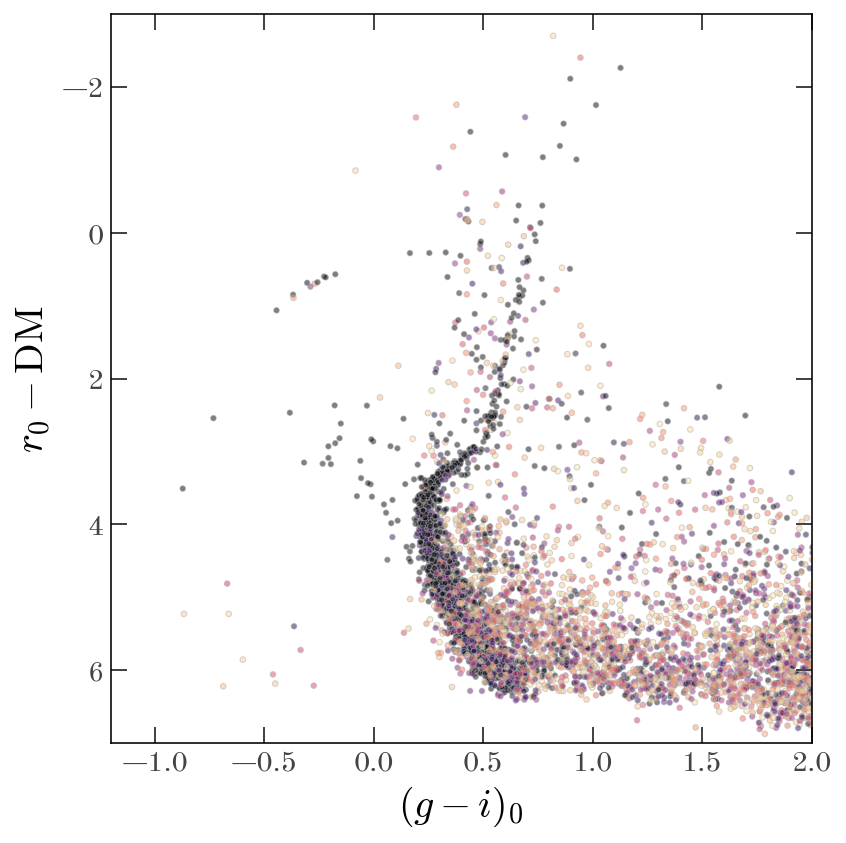

In [63]:
prob_mask = post_prob > 0.05

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    (g.g0 - g.i0)[prob_mask],
    (g.r0 - g.rough_distmod.value)[prob_mask],
    c=post_prob[prob_mask],
    s=8,
    alpha=0.5,
    linewidth=0.5,
    edgecolor='#aaaaaa',
    cmap='magma_r',
    vmin=0, vmax=1
)

ax.set_xlim(-1.2, 2)
ax.set_ylim(7., -3)

ax.set_xlabel('$(g-i)_0$')
ax.set_ylabel(r'$r_0 - {\rm DM}$')

fig.tight_layout()

For HB selection & members, plot apparent mag vs. phi1

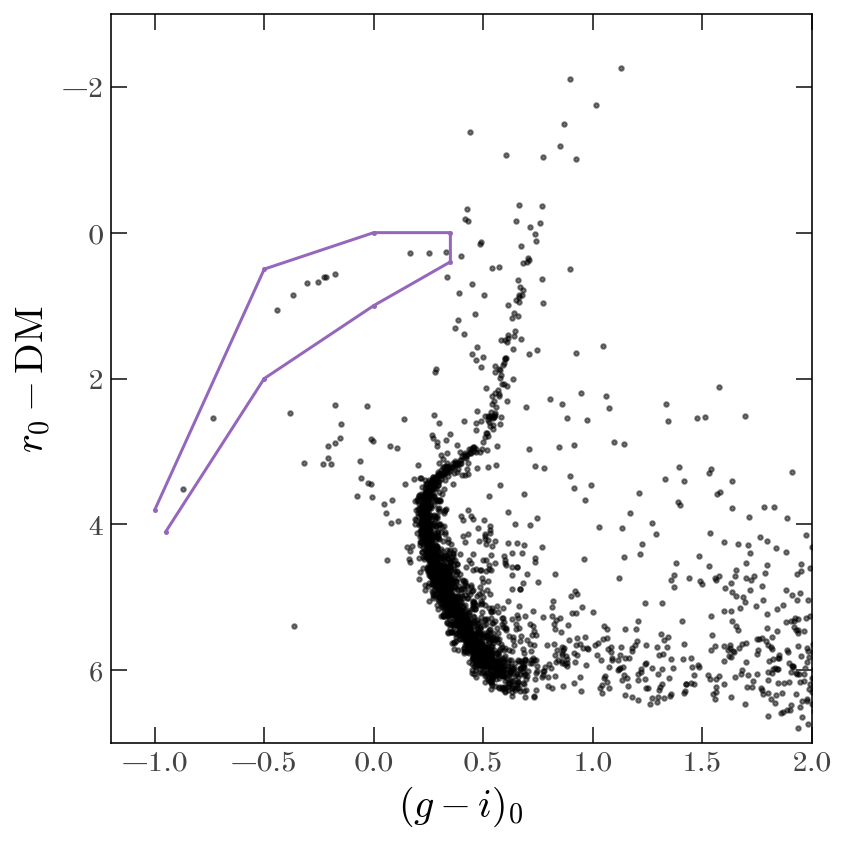

In [64]:
strict_prob_mask = post_prob > 0.8

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    (g.g0 - g.i0)[strict_prob_mask],
    (g.r0 - g.rough_distmod.value)[strict_prob_mask],
    s=5,
    alpha=0.5
)

_nodes = np.array([
    [-1, 3.8],
    [-0.5, 0.5],
    [0, 0],
    [0.35, 0],
    [0.35, 0.4],
    [0, 1],
    [-0.5, 2],
    [-0.95, 4.1]
])
hb_path = mpl.path.Path(_nodes)
ax.plot(_nodes[:, 0], _nodes[:, 1], color='tab:purple')

hb_mask = hb_path.contains_points(
    np.stack((g.g0 - g.i0, g.r0 - g.rough_distmod.value)).T
)

ax.set_xlim(-1.2, 2)
ax.set_ylim(7., -3)

ax.set_xlabel('$(g-i)_0$')
ax.set_ylabel(r'$r_0 - {\rm DM}$')

fig.tight_layout()

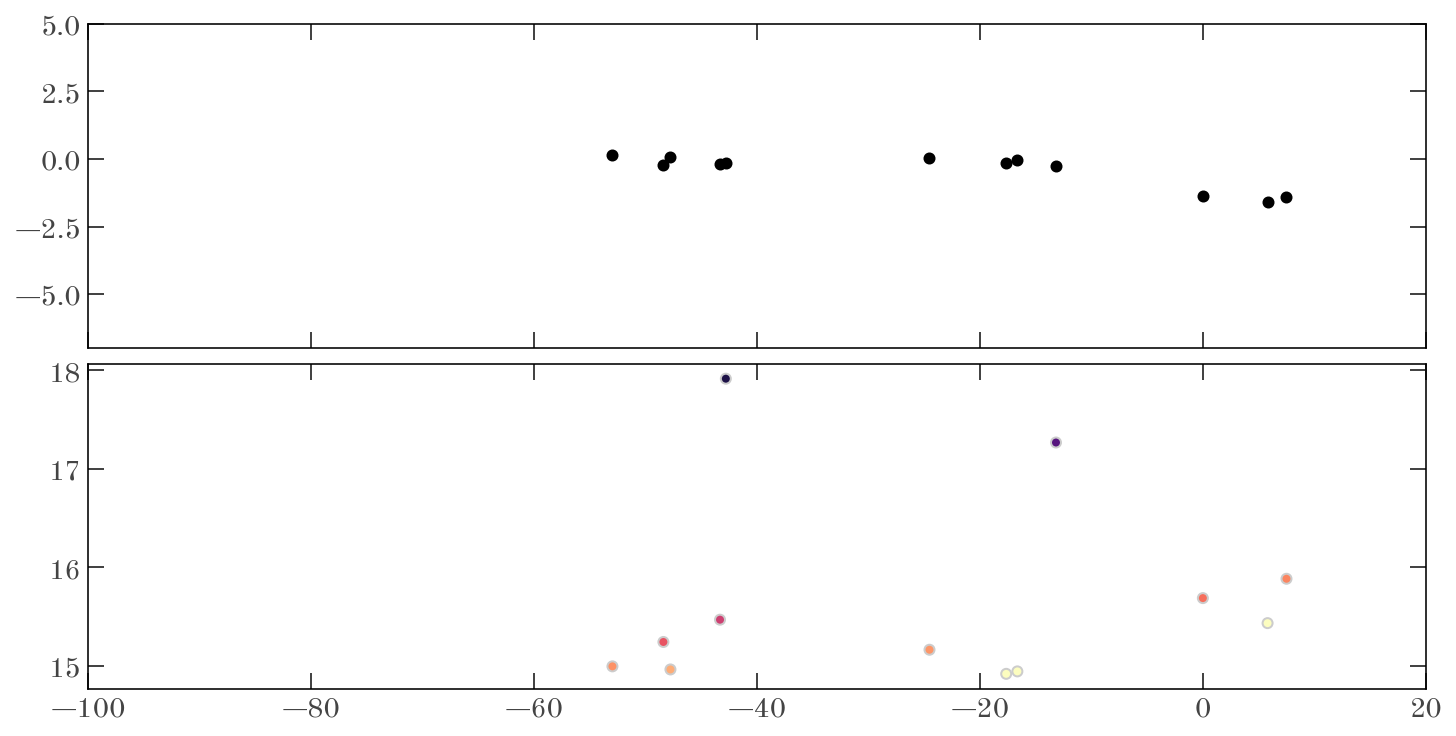

In [65]:
_mask = strict_prob_mask & hb_mask

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, constrained_layout=True)

axes[0].scatter(g.gd1_phi1[_mask], g.gd1_phi2[_mask])
axes[0].set_xlim(-100, 20)
axes[0].set_ylim(-7, 5)

axes[1].scatter(
    g.gd1_phi1[_mask], 
    g.r0[_mask], c=(g.g0 - g.i0)[_mask], 
    vmin=-1, vmax=0,
    linewidth=1,
    edgecolor='#cccccc'
)

In [66]:
wut_mask = hb_mask & (post_prob < 0.8) & (post_prob > 0.05)
wut_mask.sum()

3